In [1]:
# -- verwendete Bibliotheken
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from scipy import stats

from IPython.display import display

import pvlib
from pvlib.modelchain import ModelChain as Mc_Pva
from pvlib.location import Location 
from pvlib.pvsystem import PVSystem
from pvlib.solarposition import get_solarposition
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

from windpowerlib import ModelChain as Mc_Wka
from windpowerlib import WindTurbine

import pyomo.environ as pyo
from pyomo.opt import SolverFactory

In [2]:
# -- Einlesen der Metadaten
# Norden
df_meta_north = pd.read_csv("./Nord 00591/Metadaten.txt", sep=";", skipinitialspace=True, skipfooter=1, engine="python", encoding="latin1")
height_station_north = int(df_meta_north.iloc[-1,4]) # Für Winddaten
height_wind_north = int(df_meta_north.iloc[-1,5]) # Für Winddaten
height_station_north = float(df_meta_north.iloc[-1,4]) # Für Winddaten
latlon_north = [float(df_meta_north.iloc[-1,3]), float(df_meta_north.iloc[-1,2])]
# Osten
df_meta_east = pd.read_csv("./Ost 01048/Metadaten.txt", sep=";", skipinitialspace=True, skipfooter=1, engine="python", encoding="latin1")
height_wind_east = int(df_meta_east.iloc[-1,5]) # Für Winddaten
height_station_east = float(df_meta_east.iloc[-1,4]) # Für Winddaten
latlon_east = [float(df_meta_east.iloc[-1,3]), float(df_meta_east.iloc[-1,2])]
# Süden
df_meta_south = pd.read_csv("./Süd 05404/Metadaten.txt", sep=";", skipinitialspace=True, skipfooter=1, engine="python", encoding="latin1")
height_wind_south = int(df_meta_south.iloc[-1,5]) # Für Winddaten
height_station_south = float(df_meta_south.iloc[-1,4]) # Für Winddaten
latlon_south = [float(df_meta_south.iloc[-1,3]), float(df_meta_south.iloc[-1,2])]
# Westen
df_meta_west = pd.read_csv("./West 03098/Metadaten.txt", sep=";", skipinitialspace=True, skipfooter=1, engine="python", encoding="latin1")
height_wind_west = int(df_meta_west.iloc[-1,5]) # Für Winddaten
height_station_west = float(df_meta_west.iloc[-1,4]) # Für Winddaten
latlon_west = [float(df_meta_west.iloc[-1,3]), float(df_meta_west.iloc[-1,2])]
# Zentrum
df_meta_center = pd.read_csv("./Zentrum 03231/Metadaten.txt", sep=";", skipinitialspace=True, skipfooter=1, engine="python", encoding="latin1")
height_wind_center = int(df_meta_center.iloc[-1,5]) # Für Winddaten
height_station_center = float(df_meta_center.iloc[-1,4]) # Für Winddaten
latlon_center = [float(df_meta_center.iloc[-1,3]), float(df_meta_center.iloc[-1,2])]
# list mit jeweiligen Metadaten für späteren Zugriff
list_latlons = [latlon_north, latlon_east, latlon_south, latlon_west, latlon_center]
list_heights_wind = [height_wind_north, height_wind_east, height_wind_south, height_wind_west, height_wind_center]
list_heights_station = [height_station_north, height_station_east, height_station_south, height_station_west, height_station_center]

In [3]:
# -- Einlesen der Spotmarktpreise 
df_spotmarkt_ct_h = pd.read_csv("Spotmarktpreis [2015-2024].csv", delimiter=";", decimal=",")
# MESS_DATUM als Zeitstempel deklarieren und als Index setzen
df_spotmarkt_ct_h["MESS_DATUM"] = df_spotmarkt_ct_h["Datum"] + " " + df_spotmarkt_ct_h["von"]
df_spotmarkt_ct_h["MESS_DATUM"] = pd.to_datetime(df_spotmarkt_ct_h["MESS_DATUM"], format="%d.%m.%Y %H:%M")
df_spotmarkt_ct_h = df_spotmarkt_ct_h.set_index("MESS_DATUM")
df_spotmarkt_ct_h.index.name = None
# Anpassen des Zeitintervalls auf das Zeitintervall der anderen Daten (10 Minuten), dazu Stundenwert auf Minutenwert 
df_spotmarkt_ct_full = df_spotmarkt_ct_h[["Spotmarktpreis in ct/kWh"]].resample("10min").ffill().loc["2015-01-01 00:00:00":"2024-12-31 23:50:00",:]
display(df_spotmarkt_ct_full)
df_spotmarkt_ct = df_spotmarkt_ct_full.loc["2020-01-01 00:00:00":"2024-12-31 23:50:00",:]
# Spotmarktpreis in €/kWh für spätere Anwendungen umrechnen 
df_spotmarkt = df_spotmarkt_ct.rename(columns={"Spotmarktpreis in ct/kWh": "Spotmarktpreis [€/kWh]"})
df_spotmarkt /= 100

df_spotmarkt_full = df_spotmarkt_ct_full.rename(columns={"Spotmarktpreis in ct/kWh": "Spotmarktpreis [€/kWh]"})
df_spotmarkt_full /= 100
# - Analyse und Visualisierung 
print(f"""{df_spotmarkt_ct_h["Spotmarktpreis in ct/kWh"].nsmallest(6)} 
{df_spotmarkt_ct_h["Spotmarktpreis in ct/kWh"].nlargest(50)}""")
# Jahresdurchschnitt
df_spotmarkt_ct_year_avg = df_spotmarkt_ct.groupby(df_spotmarkt_ct.index.year).mean()
display(df_spotmarkt_ct_year_avg.rename(columns={"Spotmarktpreis in ct/kWh": "Ø Spotmarktpreis [ct/kWh]"}).T)
# Monatsdurchschnitt
df_spotmarkt_ct_month_avg = df_spotmarkt_ct.groupby(df_spotmarkt_ct.index.month).mean()
# Stundensdurchschnitt
df_spotmarkt_ct_hour_avg = df_spotmarkt_ct.groupby(df_spotmarkt_ct.index.hour).mean()

,Spotmarktpreis in ct/kWh
2015-01-01 00:00:00,1.829
2015-01-01 00:10:00,1.829
2015-01-01 00:20:00,1.829
2015-01-01 00:30:00,1.829
2015-01-01 00:40:00,1.829
...,...
2024-12-31 23:10:00,0.216
2024-12-31 23:20:00,0.216
2024-12-31 23:30:00,0.216
2024-12-31 23:40:00,0.216


2023-07-02 12:00:00   -50.000
2023-07-02 13:00:00   -39.900
2023-07-02 11:00:00   -26.692
2023-07-02 10:00:00   -16.796
2024-05-12 11:00:00   -13.545
2024-05-12 12:00:00   -13.285
Name: Spotmarktpreis in ct/kWh, dtype: float64 
2024-06-26 04:00:00    209.681
2024-06-26 18:00:00    162.242
2024-12-12 16:00:00     93.628
2024-06-26 05:00:00     91.328
2024-06-26 19:00:00     91.184
2024-06-26 17:00:00     91.071
2024-06-26 03:00:00     87.870
2022-08-29 17:00:00     87.100
2022-08-29 18:00:00     86.089
2022-08-30 17:00:00     85.546
2022-08-24 17:00:00     85.000
2022-08-29 16:00:00     83.766
2024-11-06 16:00:00     82.011
2024-12-12 15:00:00     81.898
2024-11-06 17:00:00     80.508
2022-08-26 06:00:00     80.299
2022-08-29 19:00:00     80.000
2022-08-23 17:00:00     79.495
2022-08-29 06:00:00     79.399
2022-08-30 16:00:00     79.371
2022-08-30 06:00:00     79.131
2022-08-24 18:00:00     78.356
2022-08-26 07:00:00     78.162
2022-08-26 17:00:00     78.000
2022-08-26 18:00:00     77.8

,2020,2021,2022,2023,2024
Ø Spotmarktpreis [ct/kWh],3.047174,9.685078,23.543984,9.517605,7.946029


In [4]:
# -- Prüfen ob leere Einträge im Datensatz der Spotmarktpreise enthalten sind
print(df_spotmarkt_full[df_spotmarkt_full.isna().any(axis=1)])

Empty DataFrame
Columns: [Spotmarktpreis [€/kWh]]
Index: []


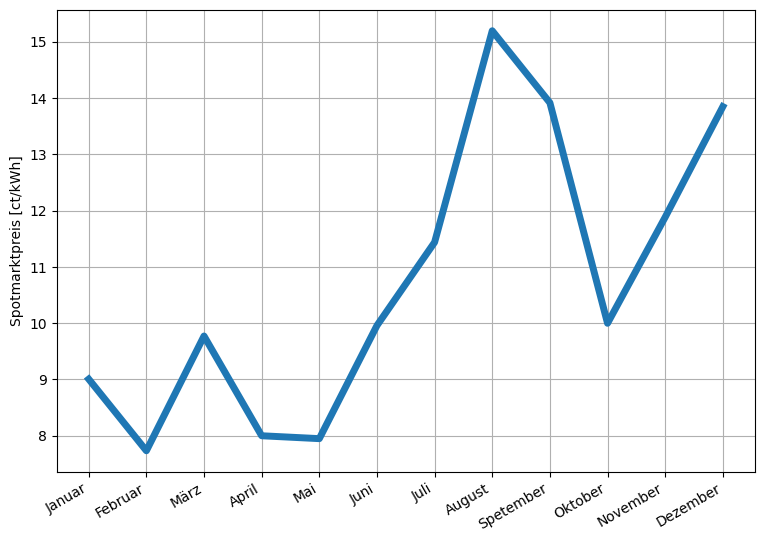

In [5]:
# -- Plot Spotmarktpreis durchschnittlich je Monat im Jahr
list_month = ["Januar", "Februar", "März", "April", "Mai", "Juni", "Juli", "August", "Spetember", "Oktober", "November", "Dezember"]
df_spotmarkt_ct_month_avg["Spotmarktpreis in ct/kWh"]

plt.figure(figsize=(9, 6))
#plt.plot(list_month, [x*0 for x in range(12)], alpha=0)
plt.plot(list_month, df_spotmarkt_ct_month_avg["Spotmarktpreis in ct/kWh"], linewidth=5)
plt.ylabel("Spotmarktpreis [ct/kWh]")
plt.xticks(rotation=30, ha="right")
plt.grid()
plt.show()

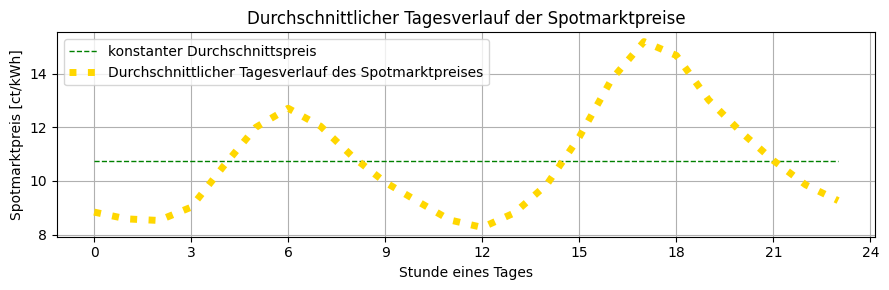

In [6]:
# -- Plot Spotmarktpreis durchschnittlich je Stunde am Tag
x = df_spotmarkt_ct_hour_avg.index
y = df_spotmarkt_ct_hour_avg["Spotmarktpreis in ct/kWh"]

plt.figure(figsize=(9, 3))
plt.hlines(y.mean(), x[0], x[-1], color="green", linewidth=1, linestyles="--", label="konstanter Durchschnittspreis")
plt.plot(x, df_spotmarkt_ct_hour_avg["Spotmarktpreis in ct/kWh"], linewidth=5, color="gold", linestyle=":", label="Durchschnittlicher Tagesverlauf des Spotmarktpreises")
plt.ylabel("Spotmarktpreis [ct/kWh]")
plt.xlabel("Stunde eines Tages")
plt.xticks(ticks=np.arange(0,25,3))
plt.title("Durchschnittlicher Tagesverlauf der Spotmarktpreise")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

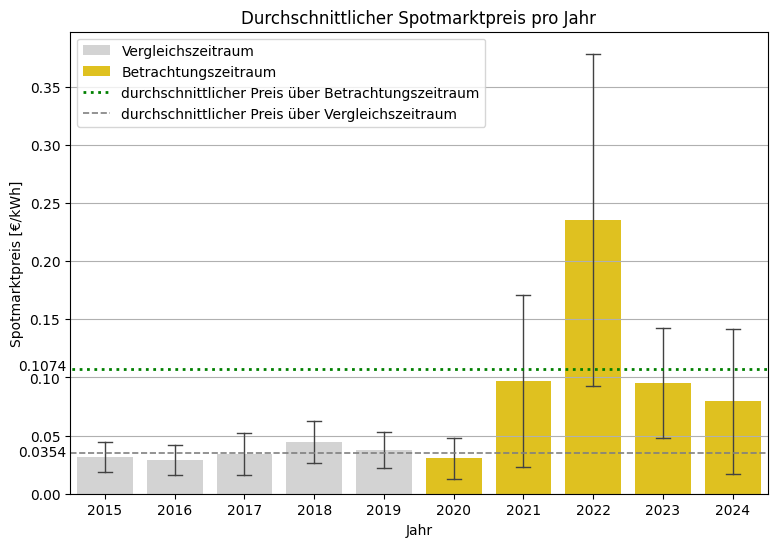

In [7]:
df_wide = df_spotmarkt_full
df_wide.loc["2015-01-01 00:00:00":"2019-12-31 23:50:00", "Gruppe"] = "Vergleichszeitraum"
df_wide.loc["2020-01-01 00:00:00":"2024-12-31 23:50:00", "Gruppe"] = "Betrachtungszeitraum"
df_wide["Year"] = df_wide.index.year

plt.figure(figsize=(9,6))
sns.barplot(data = df_wide, x="Year", y="Spotmarktpreis [€/kWh]", 
            hue="Gruppe", palette={"Vergleichszeitraum": "lightgrey", "Betrachtungszeitraum":"gold"}, 
            errorbar="sd", capsize=0.2 , err_kws={"linewidth": 1})
x = np.arange(0, 10, 1)
mean_price_observed = df_spotmarkt["Spotmarktpreis [€/kWh]"].mean()
mean_price_compare = df_spotmarkt_full.loc["2015-01-01 00:00:00":"2019-12-31 23:50:00", "Spotmarktpreis [€/kWh]"].mean()
plt.hlines(mean_price_observed, x[0] - 1, x[-1] + 1, color="green", linewidth=2, linestyles=":", label="durchschnittlicher Preis über Betrachtungszeitraum")
plt.hlines(mean_price_compare, x[0] - 1, x[-1] + 1, color="grey", linewidth=1.2, linestyles="--", label="durchschnittlicher Preis über Vergleichszeitraum")
plt.xlim(x[0] - 0.5, x[-1] + 0.5)
plt.xlabel("Jahr")
plt.title("Durchschnittlicher Spotmarktpreis pro Jahr")
plt.grid(axis="y")
plt.text(-1.25, 0.0323, f"{round(mean_price_compare, 4)}")
plt.text(-1.25, 0.1057, f"{round(mean_price_observed, 4)}")
plt.legend()
plt.show()

In [8]:
# -- Wetterdaten des Nordens einlesen und zusammenführen
# Importieren der Solardaten in J/(cm^2)
df_solar_north = pd.read_csv("./Nord 00591/solar.txt", sep=";", skipinitialspace=True, engine="python")
df_solar_north = df_solar_north.drop(columns=["STATIONS_ID", "QN", "SD_10", "LS_10", "eor"])
# Importieren der Winddaten in m/s
df_wind_north = pd.read_csv("./Nord 00591/wind.txt", sep=";", skipinitialspace=True, engine="python")
df_wind_north = df_wind_north.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "DD_10", "eor"])
# Importieren der Lufttemperaturdaten in 2 m Höhe in °C
df_temperature_north = pd.read_csv("./Nord 00591/temperatur.txt", sep=";", skipinitialspace=True, engine="python")
df_temperature_north = df_temperature_north.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "TM5_10", "RF_10", "TD_10", "eor"])
# Zusammenführen
df_north = df_solar_north.join([df_wind_north, df_temperature_north], how="outer")

In [9]:
# -- Wetterdaten des Ostens einlesen und zusammenführen
# Importieren der Solardaten in J/(cm^2)
df_solar_east = pd.read_csv("./Ost 01048/solar.txt", sep=";", skipinitialspace=True, engine="python")
df_solar_east = df_solar_east.drop(columns=["STATIONS_ID", "QN", "SD_10", "LS_10", "eor"])
# Importieren der Winddaten in m/s
df_wind_east = pd.read_csv("./Ost 01048/wind.txt", sep=";", skipinitialspace=True, engine="python")
df_wind_east = df_wind_east.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "DD_10", "eor"])
# Importieren der Lufttemperaturdaten in 2 m Höhe in °C
df_temperature_east = pd.read_csv("./Ost 01048/temperatur.txt", sep=";", skipinitialspace=True, engine="python")
df_temperature_east = df_temperature_east.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "TM5_10", "RF_10", "TD_10", "eor"])
# Zusammenführen
df_east = df_solar_east.join([df_wind_east, df_temperature_east], how="outer")

In [10]:
# -- Wetterdaten des Südens einlesen und zusammenführen
# Importieren der Solardaten in J/(cm^2)
df_solar_south = pd.read_csv("./Süd 05404/solar.txt", sep=";", skipinitialspace=True, engine="python")
df_solar_south = df_solar_south.drop(columns=["STATIONS_ID", "QN", "SD_10", "LS_10", "eor"])
# Importieren der Winddaten in m/s
df_wind_south = pd.read_csv("./Süd 05404/wind.txt", sep=";", skipinitialspace=True, engine="python")
df_wind_south = df_wind_south.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "DD_10", "eor"])
# Importieren der Lufttemperaturdaten in 2 m Höhe in °C
df_temperature_south = pd.read_csv("./Süd 05404/temperatur.txt", sep=";", skipinitialspace=True, engine="python")
df_temperature_south = df_temperature_south.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "TM5_10", "RF_10", "TD_10", "eor"])
# Zusammenführen
df_south = df_solar_south.join([df_wind_south, df_temperature_south], how="outer")

In [11]:
# -- Wetterdaten des Westens einlesen und zusammenführen
# Importieren der Solardaten in J/(cm^2)
df_solar_west = pd.read_csv("./West 03098/solar.txt", sep=";", skipinitialspace=True, engine="python")
df_solar_west = df_solar_west.drop(columns=["STATIONS_ID", "QN", "SD_10", "LS_10", "eor"])
# Importieren der Winddaten in m/s
df_wind_west = pd.read_csv("./West 03098/wind.txt", sep=";", skipinitialspace=True, engine="python")
df_wind_west = df_wind_west.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "DD_10", "eor"])
# Importieren der Lufttemperaturdaten in 2 m Höhe in °C
df_temperature_west = pd.read_csv("./West 03098/temperatur.txt", sep=";", skipinitialspace=True, engine="python")
df_temperature_west = df_temperature_west.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "TM5_10", "RF_10", "TD_10", "eor"])
# Zusammenführen
df_west = df_solar_west.join([df_wind_west, df_temperature_west], how="outer")

In [12]:
# -- Wetterdaten des Zentrums einlesen und zusammenführen
# Importieren der Solardaten in J/(cm^2)
df_solar_center = pd.read_csv("./Zentrum 03231/solar.txt", sep=";", skipinitialspace=True, engine="python")
df_solar_center = df_solar_center.drop(columns=["STATIONS_ID", "QN", "SD_10", "LS_10", "eor"])
# Importieren der Winddaten in m/s
df_wind_center = pd.read_csv("./Zentrum 03231/wind.txt", sep=";", skipinitialspace=True, engine="python")
df_wind_center = df_wind_center.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "DD_10", "eor"])
# Importieren der Lufttemperaturdaten in 2 m Höhe in °C
df_temperature_center = pd.read_csv("./Zentrum 03231/temperatur.txt", sep=";", skipinitialspace=True, engine="python")
df_temperature_center = df_temperature_center.drop(columns=["MESS_DATUM", "STATIONS_ID", "QN", "TM5_10", "RF_10", "TD_10", "eor"])
# Zusammenführen
df_center = df_solar_center.join([df_wind_center, df_temperature_center], how="outer")

In [13]:
# -- Bereinigung der Daten - Ersetzen von Fehlerwert -999 durch Durchschnittswert zur gleichen Zeit der anderen Jahre
dict_error = {}
list_str_cardinal_direct = ["Norden", "Osten", "Süden", "Westen", "Zentrum"]
list_str_cardinal_direct_eng = ["north", "east", "south", "west", "center"]
indexdiff_one_year = 6 * 24 * 365 # Anzahl Indices pro Jahr - Schaltjahr vernachlässigt, da Verschiebung um 10 Minuten nur kleinen Einfluss
list_df_cardinal_direct = [df_north, df_east, df_south, df_west, df_center] # Bereinigung für jeden Datensatz
list_years = ["2020", "2021", "2022", "2023", "2024"] # Bereinigung für jedes Jahr, anhand der anderen Jahre
list_colnames = df_north.columns.astype(str)[1:] # north wird zwar genommen, jedoch gelten die Spaltennamen für alle Anlagen
for i_cd, df_cardinal_direct in enumerate(list_df_cardinal_direct):
    dict_error_measurement = {}
    for measurement in list_colnames: # Für alle gemessenen Werte (Solar -globale und diffuse Strahlung, Wind, Temperatur)
        counter_error_measurement = 0
        for index in range(df_cardinal_direct.shape[0]): # Für jeden Index (bzw. jeden Zeitstempel)
            if df_cardinal_direct.loc[index, measurement] == -999: # Alle Einträge, die Fehlerwert -999 haben
                counter_error_measurement += 1
                year_diff = 0 # Korrekturwert, der die Vergleichsjahre relativ zum betrachteten Jahr setzt
                for year in list_years: 
                    if str(df_cardinal_direct.iloc[index, 0])[:4] == year: # Filtern aufs jeweilige Jahr für spezielle Anwendung
                        list_compare_value = [] # Vergleichswerte zur gleichen Zeit aus den anderen Jahren werden hier eingefügt
                        list_manipulated_compare_factors = [(0-year_diff), (1-year_diff), (2-year_diff), (3-year_diff), (4-year_diff)]
                        for compare_factor in list_manipulated_compare_factors: # Zahlen in Liste stehen für järlichen Abstand, bsp. -1 => 1 Jahr Vergangenheit, 2 => 2 Jahre Zukunft
                            if df_cardinal_direct.loc[(index + indexdiff_one_year * compare_factor), measurement] != -999: # Filterung der Vergleichswerte mit Fehlerwert
                                list_compare_value.append(df_cardinal_direct.loc[(index + indexdiff_one_year * compare_factor), measurement])
                        df_cardinal_direct.loc[index, measurement] = np.mean(list_compare_value) # Fehlerwert durch Durchschnitt der Vergleichswerte ersetzen
                    year_diff += 1
        dict_error_measurement[measurement] = counter_error_measurement
    dict_error[list_str_cardinal_direct[i_cd]] = dict_error_measurement
    df_cardinal_direct["MESS_DATUM"] = pd.to_datetime(df_cardinal_direct["MESS_DATUM"], format="%Y%m%d%H%M") # Zeitstempel richtig einlesen
    df_cardinal_direct = df_cardinal_direct.rename(
        columns={"DS_10": "dhi", "GS_10": "ghi", "FF_10": "wind_speed", "TT_10": "temp_air", "PP_10": "pressure"}
    )
    df_cardinal_direct = df_cardinal_direct.set_index("MESS_DATUM")
    df_cardinal_direct.index.name = None
    df_cardinal_direct["ghi"] *= (10000 / 600) # Umrechnungsfaktor von J/(cm² * 10min) in Ø W/(m²)
    df_cardinal_direct["dhi"] *= (10000 / 600) # Umrechnungsfaktor von J/(cm² * 10min) in Ø W/(m²)
    df_cardinal_direct["pressure"] *= 100 # Umrechnungsfaktor hPa in Pa    
    df_cardinal_direct["Ø globale Einstrahlung [kWh/(m²a)]"] = df_cardinal_direct["ghi"] * 8.76 # Umrechnungfaktor von W/(m²) in kWh/(m²a)
    list_df_cardinal_direct[i_cd] = df_cardinal_direct
df_error = pd.DataFrame(dict_error)
df_error = df_error.rename(index={
    "DS_10": "diffuse horizontale Einstrahlung",
    "GS_10": "globale horizontale Einstrahlung",
    "FF_10": "Windgeschwindigkeit",
    "PP_10": "Luftdruck",
    "TT_10": "Temperatur in 2 m Höhe"
})
df_error.index.name = "Anzahl Fehlwerte"
display(df_error)


,Norden,Osten,Süden,Westen,Zentrum
Anzahl Fehlwerte,,,,,
diffuse horizontale Einstrahlung,604,15093,6909,572,505
globale horizontale Einstrahlung,604,71,2447,573,505
Windgeschwindigkeit,329,34,1242,1002,472
Luftdruck,44,0,475,39,322
Temperatur in 2 m Höhe,64,0,588,39,0


In [14]:
# -- Gegenprüfung der Fehlwertbereinigung (Als Kommentar makiert, da Prozess nicht jedes Mal durchgelaufen werden muss)
for i_cd, df in enumerate(list_df_cardinal_direct):
    for index in range(len(df)):
        for measurement in range(5):
            if df.iloc[index, measurement] < -20:
                print(i_cd, index, measurement, df.iloc[index, measurement])

In [15]:
# -- 5-Jahresdurchschnitte der Wetterdaten aller Anlagen
dict_weather_mean = {}
list_weather_columns = []

for i_cd, df in enumerate(list_df_cardinal_direct):
    dict_colnames_weather_temp = {}
    list_weather_columns = [colname for colname in df.columns]
    for colname in df.columns:
        dict_colnames_weather_temp[colname] = float(round(df[colname].mean(), 2))
    dict_weather_mean[list_str_cardinal_direct[i_cd]] = dict_colnames_weather_temp
    
df_weather_mean = pd.DataFrame(data=dict_weather_mean)
df_weather_mean = df_weather_mean.rename(index={
    "dhi": "Ø diffuse Einstrahlung [W/m²]", 
    "ghi": "Ø globale Einstrahlung [W/m²]",
    "wind_speed": "Ø Windgeschwindigkeit [m/s]",
    "pressure": "Ø Luftdruck [Pa]",
    "Ø globale Einstrahlung [kWh/(m²a)]": "Ø globale Einstrahlungsenergie [kWh/(m²a)]",
	"temp_air": "Ø Lufttemperatur [°C]"
}).sort_index()

series_heights_station = pd.Series(list_heights_station, name="Anlagenhöhe [m ü. NHN]", index=df_weather_mean.columns)
Series_heights_wind = pd.Series(list_heights_wind, name="Windmesshöhe über Grund [m]", index=df_weather_mean.columns)
df_weather_mean = pd.concat((df_weather_mean.T, series_heights_station, Series_heights_wind), axis=1).T
df_weather_mean

,Norden,Osten,Süden,Westen,Zentrum
Ø Luftdruck [Pa],100946.36,98851.13,96108.67,96985.62,96332.04
Ø Lufttemperatur [°C],10.60,10.91,9.86,9.90,9.40
Ø Windgeschwindigkeit [m/s],3.38,4.14,2.75,3.15,3.02
Ø diffuse Einstrahlung [W/m²],62.56,57.11,59.04,64.26,62.45
Ø globale Einstrahlung [W/m²],126.09,131.81,143.62,123.34,125.76
Ø globale Einstrahlungsenergie [kWh/(m²a)],1104.53,1154.62,1258.10,1080.43,1101.62
Anlagenhöhe [m ü. NHN],44.72,227.57,477.10,386.70,450.00
Windmesshöhe über Grund [m],15.00,10.00,10.00,13.00,12.00


In [16]:
sandia_module = pvlib.pvsystem.retrieve_sam("SandiaMod")
sandia_module.loc["Nennleistung"] = sandia_module.loc["Impo"] * sandia_module.loc["Vmpo"]
sandia_module.loc["Nennleistung", :][(sandia_module.loc["Nennleistung", :] >= 250) & (sandia_module.loc["Nennleistung", :] <= 270)]

Schott_Solar_ASE_250_DGF_50__250___2007__E__        251.16
Schott_Solar_ASE_270_DGF_50__260___2007__E__        258.11
Schott_Solar_ASE_300_DGF_17__265___1999__E__        265.44
Schott_Solar_ASE_300_DGF_50__265___1999__E__         265.0
Suntech_STP260S_24_Vb__2007__E__                    260.05
Suntech_STP270S_24_Vb__2007__E__                    269.85
Suntech_STP270S_24_Vb_Module___2008_            265.472504
Suntech_STP270S_24_Vb_Module__2008__E__             269.85
Name: Nennleistung, dtype: object

In [17]:
# -- Modell der Berechnung der PVA-Erzeugungsdaten
dict_pva = {}
list_module_choice = ["Canadian_Solar_CS5P_220M___2009_", "Schott_Solar_ASE_270_DGF_50__260___2007__E__"] 
# system zur Berechnung erstellen
sandia_modules = pvlib.pvsystem.retrieve_sam("SandiaMod") # Datenbank für Solarmodule
cec_inverters = pvlib.pvsystem.retrieve_sam("CECInverter") # Datenbank für Wechselrichter
module = sandia_modules[list_module_choice[0]] # Referenzkonstellation 0: "Canadian_Solar_CS5P_220M___2009_"
inverter = cec_inverters["ABB__MICRO_0_25_I_OUTD_US_208__208V_"] 

temperature_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"]["open_rack_glass_glass"]

all_min_temps = [df["temp_air"].min() for df in list_df_cardinal_direct]
min_temperature = min(all_min_temps) # -18.1
# Modul- und Wechselrichterkonfiguration
def modulecount():
    max_dc_power_inverter = inverter["Pdco"] # max. zulässige PV-Leistung
    max_power_module = module["Impo"] * module["Vmpo"]
    max_modulecount = int(max_dc_power_inverter / max_power_module) # Maximale Modulanzahl pro Inverter
    V_oc_min_module = module["Voco"] * (1 + (module["Bvoco"] / 100) * (25 - min_temperature)) # Leerlaufspannung bei niedrigster Temperatur
    I_sc_module = module["Isco"]
    max_modules_per_string = int(inverter["Vdcmax"] / V_oc_min_module) # Maximale Modulanzahl pro String, max. WR-Spannung nicht überschreiten
    max_strings_per_inverter = int(inverter["Idcmax"] / I_sc_module)
    dict_modulecount = {
        "max_power_module": max_power_module,
        "max_module_per_string": max_modules_per_string,
        "max_strings_per_inverter": max_strings_per_inverter,
        "max_modules_per_inverter": max_modulecount,
        "max_dc_power_inverter": max_dc_power_inverter
    } # veraltet: {'strings': 3, 'modules_per_string': 8, 'modules_per_inverter': 28, 'dc_power': 5271.761498976}
    return dict_modulecount
moduleconfig = modulecount()
print(moduleconfig) # sollte für Auslegung verwendet werden, jedoch nicht optimal, wird nur noch für Informationen verwendet
modules_per_string = 1
strings_per_inverter = 1
max_dc_power = moduleconfig["max_power_module"] * modules_per_string * strings_per_inverter

system_pva = PVSystem(
    surface_tilt=30, 
    surface_azimuth=180, 
    module_parameters=module, 
    inverter_parameters=inverter, 
    temperature_model_parameters=temperature_parameters,
    modules_per_string=modules_per_string,
    strings_per_inverter=strings_per_inverter
)
# Jeder Anlage anhand ihrer Metadaten eine Location und eine ModelChain zuordnen, mit der die Erzeugungsdaten berechnet werden
list_locations = []
for i_cd, df in enumerate(list_df_cardinal_direct): # i_cd ist ein Index, wobei 0=Norden, 1=Osten, ..., 4=Zentrum
    latitude = list_latlons[i_cd][0]
    longitude = list_latlons[i_cd][1]
    altitude = list_heights_station[i_cd]
    location = Location(
        latitude=latitude, 
        longitude=longitude,
        altitude=altitude,
        tz="Europe/Berlin"
    )
    list_locations.append(location)

    modelchain_pva = Mc_Pva(
        system=system_pva, 
        location=location,
        aoi_model="sapm",
        spectral_model="sapm",
        losses_model="pvwatts"
    )
    print(modelchain_pva.system.pvwatts_losses())
    # Direktstrahlung (dni) anhand von Globalstrahlung (ghi), Diffusstrahlung (dhi) und Sonnenzenith berechnen
    solpos = get_solarposition(
        time=df.index, 
        latitude=latitude, 
        longitude=longitude,
        altitude=altitude
        ) # Sonnenposition berechnen
    dni = pvlib.irradiance.dirint(
        ghi=df["ghi"],
        solar_zenith=solpos["zenith"],
        times=df.index,
        pressure=df["pressure"],
    ) # ghi = dhi + dni * cos(theta)
    df["dni"] = dni.clip(lower=0)
    # ModelChains durchführen und results speichern
    modelchain_pva.run_model(df) # ModelChain für jeweiliges Dataframe erstellen - Nutzt Spalten temp_air, ghi, dni und dhi
    scaling_factor_pva = 1_000_000 / max_dc_power

    ac = modelchain_pva.results.ac.copy()
    ac = ac.clip(lower=0).fillna(0)

    P_pva_scalable = ac * scaling_factor_pva # auf 1.000.000 W (1 MW) skaliert
    list_df_cardinal_direct[i_cd]["P_pva_scalable"] = P_pva_scalable # Ergebnisse in dict abspeichern

    # Nur für Visualisierung
    ac = ac # .loc["2020-05-18 12:20:00":"2020-05-18 14:20:00"]
    dc = modelchain_pva.results.dc.p_mp.clip(lower=0).fillna(0) # .loc["2020-05-18 12:20:00":"2020-05-18 14:20:00"]

    dc_power = (dc * scaling_factor_pva).mean() 
    inverter_efficiency_weighted_percent = (ac.mean() / dc.mean()) * 100
    inverter_efficiency_unweighted_percent = (ac / dc).mean() * 100
    effective_irradiance = modelchain_pva.results.total_irrad["poa_global"].fillna(0).mean()

    dict_pva_temp = {
        "Ø DC-Leistung [kW]": (dc_power / 1_000), 
        "Ø AC-Leistung [kW]": (P_pva_scalable.mean() / 1_000),
        "Ø WR-Wirkungsgrad (gewichtet) [%]": inverter_efficiency_weighted_percent, 
        "Ø WR-Wirkungsgrad (ungewichtet) [%]": inverter_efficiency_unweighted_percent, 
        "Ø Globalstrahlung Modulebene [W/m²]": effective_irradiance,
        "Ø Volllaststunden [h/a]": ((P_pva_scalable.mean() / 1_000_000 ) * 8760)
    }
    dict_pva[list_str_cardinal_direct[i_cd]] = dict_pva_temp

df_pva = pd.DataFrame(dict_pva)
display(df_pva.round(2))

{'max_power_module': 219.656729124, 'max_module_per_string': 0, 'max_strings_per_inverter': 1, 'max_modules_per_inverter': 1, 'max_dc_power_inverter': 259.588593}
14.075660688264469
14.075660688264469
14.075660688264469
14.075660688264469
14.075660688264469


,Norden,Osten,Süden,Westen,Zentrum
Ø DC-Leistung [kW],121.68,121.59,130.21,118.07,115.89
Ø AC-Leistung [kW],114.62,114.46,122.85,111.22,109.08
Ø WR-Wirkungsgrad (gewichtet) [%],94.19,94.14,94.34,94.19,94.13
Ø WR-Wirkungsgrad (ungewichtet) [%],79.19,79.92,81.17,78.54,78.62
Ø Globalstrahlung Modulebene [W/m²],152.99,152.60,163.84,147.58,145.00
Ø Volllaststunden [h/a],1004.05,1002.71,1076.13,974.26,955.56


In [18]:
module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                           -0.01284
Bvoco                                                        -0.21696
Mbvoc               

In [19]:
inverter

Vac                          208
Pso                     2.089607
Paco                       250.0
Pdco                  259.588593
Vdco                        40.0
C0                     -0.000041
C1                     -0.000091
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                      50.0
Idcmax                  6.489715
Mppt_low                    30.0
Mppt_high                   50.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

##### Wieringa, J. (1993). Updating the Davenport roughness classification. Journal of Wind Engineering and Industrial Aerodynamics, 46-47, 357–368. https://doi.org/10.1016/0167-6105(92)90434-C

Table 4: Davenport Roughness Classification (revised)

Class	z0z0​ (m)	-   Description

1.	0.0002	"Sea" – Open sea or lake (irrespective of the wave size), tidal flat, snow-covered flat plain, featureless desert, tarmac and concrete, with a free fetch of several kilometers.

2.	0.005	"Smooth" – Featureless land surface without any noticeable obstacles and with negligible vegetation; e.g. beaches, pack ice without large ridges, morass, and snow-covered or fallow open country.

3.	0.03	"Open" – Level country with low vegetation (e.g. grass) and isolated obstacles with separations of at least 50 obstacle heights; e.g. grazing land without windbreaks, heather, moor and tundra, runway area of airports.

4.	0.10	"Roughly open" – Cultivated area with regular cover of low crops, or moderately open country with occasional obstacles (e.g. low hedges, single rows of trees, isolated farms) at relative horizontal distances of at least 20 obstacle heights.

5.	0.25	"Rough" – Recently-developed "young" landscape with high crops or crops of varying height, and scattered obstacles (e.g. dense shelterbelts, vineyards) at relative distances of about 15 obstacle heights.

6.	0.50	"Very rough" – "Old" cultivated landscape with many rather large obstacle groups (large farms, clumps of forest) separated by open spaces of about 10 obstacle heights. Also low large vegetation with small interspaces, such as bushland, orchards, young densely-planted forest.

7.	1.0	"Closed" – Landscape totally and quite regularly covered with similar-size large obstacles, with open spaces comparable to the obstacle heights; e.g. mature regular forests, homogeneous cities or villages.

8.	\>2	"Chaotic" – Centres of large towns with mixture of low-rise and high-rise buildings. Also irregular large forests with many clearings.

###### für windpowerlib muss die Rauigkeitslänge anhand Weiringers Tabelle von Satelitenbilder näherungsweise abgeschätzt werden, da keine Daten vorliegen.

Typ: SWT142/3150
Nennleistung (W): 3150000.0
Rotordurchmesser (m): 142.0
Rotorfläche (m²): 15836.769
Spezifische Nennleistung: 198.904


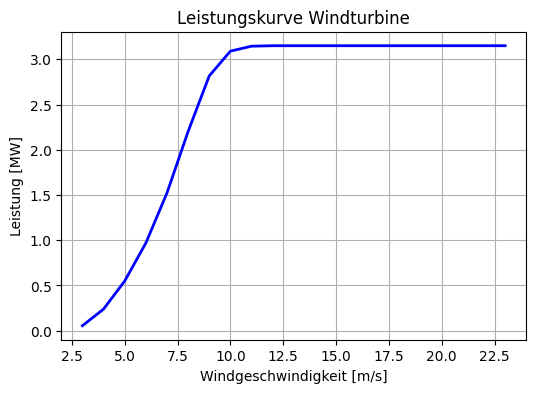

In [20]:
# -- Definieren und Visualisierung der Windturbine
x_cl = 0 # 0: SWT142/3150 (Referenzkonstellation); 1: E-101/3050
check_list_turbine = [ "SWT142/3150","E-101/3050"]  # Beispielhafte Turbinen
check_list_hub_height = [129, 135]

turbine = WindTurbine(hub_height=check_list_hub_height[x_cl], turbine_type=check_list_turbine[x_cl])

# Visualisierung
rotor_area = turbine.rotor_diameter ** 2 * np.pi / 4
spez_nominal_power = turbine.nominal_power / rotor_area
print("Typ:", turbine.turbine_type)
print("Nennleistung (W):", turbine.nominal_power)
print("Rotordurchmesser (m):", turbine.rotor_diameter)
print("Rotorfläche (m²):", round(rotor_area, 3))
print(f"Spezifische Nennleistung: {(round(spez_nominal_power, 3))}")

x = turbine.power_curve["wind_speed"]
y_power_curve = turbine.power_curve["value"] / 1_000_000
y_power_coefficient_curve = turbine.power_coefficient_curve["value"]

fig, ax1_wind = plt.subplots(figsize=(6, 4))

line1, = ax1_wind.plot(x, y_power_curve, linewidth=2, color="blue", label="Leistung")
ax1_wind.set_ylabel("Leistung [MW]")
ax1_wind.set_xlabel("Windgeschwindigkeit [m/s]")
plt.grid()

# ax2_wind = ax1_wind.twinx()
# line2, = ax2_wind.plot(x, y_power_coefficient_curve, linewidth=1, color="black", label="Leistungskoeffizient", linestyle=":")
# ax2_wind.set_ylim(0, 1)
# ax2_wind.set_ylabel("Leistungskoeffizient")

lines = [line1]#, line2]
lables = [l.get_label() for l in lines]

#plt.legend(lines, lables, loc=5)
plt.title("Leistungskurve Windturbine")
plt.show()

In [21]:
# -- Modell zur Berechnung der WKA-Erzeugungsdaten
dict_wka = {}
modelchain_wka = Mc_Wka(turbine, density_correction=True)
# Norden (rough: 0,25) - Freie Fläche, im direkten Umfeld wenige kleine Gebäude und mehrere kleinere Baumketten
# Osten (open - roughly open: 0,05) - im direkten Umfeld viel frei Fläche / Flughafenlandefläche, über 500 m Abstand zur Stadt
# Süden (rough:  0,25) - Getreidefläche, Stadt- und Waldnähe ca 300-500 Meter
# Westen (rough - very rough: 0.4) - kleine Siedlungen und Baumgruppen in der Nähe, überwiegend viel freie oder Anbaufläche
# Zentrum (very rough - closed: 0,6) - Am Zipfel einer kleinen Stadt mit kleinen Gebäuden, nach Norden viel freie Fläche
factor_rough_len_sens = 1 # =1, für gewöhnlich
list_roughness_lenght = [
    0.25 * factor_rough_len_sens, 
    0.05 * factor_rough_len_sens, 
    0.25 * factor_rough_len_sens, 
    0.4 * factor_rough_len_sens, 
    0.6 * factor_rough_len_sens]
print(list_roughness_lenght)

for i_cd, df in enumerate(list_df_cardinal_direct):
    df_wind_temp = df[["wind_speed", "pressure", "temp_air"]].rename(columns={"temp_air": "temperature"}) # temporäres DataFrame
    df_wind_temp["temperature"] += 273.15
    df_wind_temp["roughness_length"] = list_roughness_lenght[i_cd] # Rauigkeitslänge entsprechend zuordnen
    colnames_df_wind_temp = pd.MultiIndex.from_tuples(
        [
            ("wind_speed", list_heights_wind[i_cd]), # Höhe der Messgeräte der Windgeschwindigkeit aus Metadaten
            ("pressure", 0), # auf Stationshöhe gemessen
            ("temperature", 2), # 2 Meter über dem Grund
            ("roughness_length", 0) # aus Satellitenbilder geschätzt
        ], 
        names=["Value", "Height"]
    ) # windpowerlib benötigt einen Multiindex der die Höhe der Messgeräte angibt
    df_wind_temp.columns = colnames_df_wind_temp
    modelchain_wka.run_model(df_wind_temp)
    factor_wka_loss = 0.15
    P_wka = pd.Series(modelchain_wka.power_output) * (1-factor_wka_loss)
    scaling_factor_wka = 1_000_000 / turbine.nominal_power
    P_wka_scalable = P_wka * scaling_factor_wka # auf 1.000.000 W (1 MW) skaliert
    list_df_cardinal_direct[i_cd]["P_wka_scalable"] = P_wka_scalable
    # Visualisierung
    if df is list_df_cardinal_direct[0]:
        v_hub_series = modelchain_wka.wind_speed_hub(df_wind_temp)
        v_hub = v_hub_series.loc["2022-02-19 00:10:00"]
        print(
            "(max. v,wind,turbine = 23 m/s) Beispielhaftes überprüfen: WKA-Leistung:", P_wka_scalable.loc["2022-02-19 00:10:00"], 
            "v_wind,data:", df.loc["2022-02-19 00:10:00","wind_speed"], 
            "v_wind,hub:", v_hub.round(2), "m/s"
        )
    dict_wka[list_str_cardinal_direct[i_cd]] = {
        "Ø Leistung [kW]": (P_wka_scalable.mean() / 1_000).round(2),
        "Ø Windgeschwindigkeit Nabenhöhe [m/s]": modelchain_wka.wind_speed_hub(df_wind_temp).mean().round(2),
        "Ø Windgeschwindigkeit Messhöhe [m/s]": round(df["wind_speed"].mean(), 2).item(),
        "Ø Luftdichte Nabenhöhe [kg/m³]": modelchain_wka.density_hub(df_wind_temp).mean().round(2),
        "Rauigkeitslänge [m]": round(list_roughness_lenght[i_cd], 2),
        "Messhöhe Windgeschwindigkeit [m]": round(list_heights_wind[i_cd], 2),
        "Ø Volllaststunden [h/a]": round(((P_wka_scalable.mean() / 1_000_000) * 8760), 2)
    } # Leistung des Windes noch ergenzen?

df_wka = pd.DataFrame(dict_wka)
display(df_wka)

[0.25, 0.05, 0.25, 0.4, 0.6]
(max. v,wind,turbine = 23 m/s) Beispielhaftes überprüfen: WKA-Leistung: 0.0 v_wind,data: 15.8 v_wind,hub: 24.1 m/s


,Norden,Osten,Süden,Westen,Zentrum
Ø Leistung [kW],230.77,316.43,205.10,247.86,259.15
Ø Windgeschwindigkeit Nabenhöhe [m/s],5.15,6.14,4.66,5.23,5.41
Ø Windgeschwindigkeit Messhöhe [m/s],3.38,4.14,2.75,3.15,3.02
Ø Luftdichte Nabenhöhe [kg/m³],1.22,1.20,1.17,1.18,1.17
Rauigkeitslänge [m],0.25,0.05,0.25,0.40,0.60
Messhöhe Windgeschwindigkeit [m],15.00,10.00,10.00,13.00,12.00
Ø Volllaststunden [h/a],2021.52,2771.96,1796.64,2171.23,2270.16


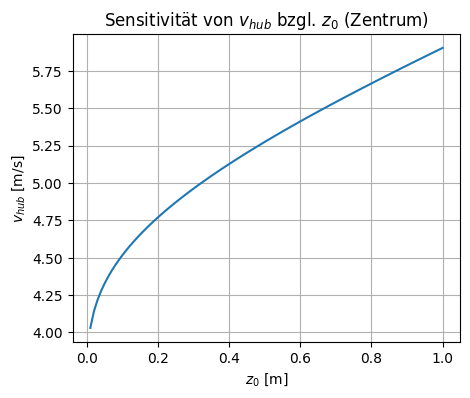

In [22]:
# -- Visualisierung der Sensitivität von Windgeschwindigkeit auf Nabenhöhe bzgl. Rauigkeitslänge
plt.figure(figsize=(5, 4))

z0_values = [x * 0.01 + 0.01 for x in range(0, 100)]  # z0 von 0.01 m bis 1.01 m, Null wegen Division nicht berücksichtigen
h_hub = 129 # Nabenhöhe
h_data = list_heights_wind[4] # Messhöhe der Windgeschwindigkeit, bsp. Zentrum
v_data = list_df_cardinal_direct[4]["wind_speed"].mean() # Durchschnitt Windgeschwindigkeit, bsp. Zentrum

v_hub = [v_data * np.log(h_hub / z0) / np.log(h_data / z0) for z0 in z0_values] # Windgeschwindigkeit auf Nabenhöhe, bsp. Zentrum

plt.plot(z0_values, v_hub)
plt.xlabel("$z_0$ [m]")
plt.ylabel("$v_{hub}$ [m/s]")
plt.title("Sensitivität von $v_{hub}$ bzgl. $z_0$ (Zentrum)")
plt.grid()
plt.show()

In [23]:
# -- DataFrames für tägliche, wöchentliche, monatliche Mittelwerte erstellen und mit stochastischen Koeffizienten im dict_data speichern
dict_data_temp = {
    "north": list_df_cardinal_direct[0], 
    "east": list_df_cardinal_direct[1], 
    "south": list_df_cardinal_direct[2], 
    "west": list_df_cardinal_direct[3], 
    "center": list_df_cardinal_direct[4]
} # temporäres dict um richtiges dict zu erstellen
dict_data = {}
dict_corr_whole_vis ={}
i_cd = 0 # Index um location in der for-Schleife zuzuordnen
for key_cardinal_direct, value_df in dict_data_temp.items():
    # Dataframes mit verschiedenen Zeitschritten erstellen
    df_10 = value_df
    df_hour = df_10.resample("h").mean()
    df_day = df_10.resample("D").mean()
    df_week = df_10.resample("W").mean() 
    df_month = df_10.resample("ME").mean()
    # Korrelationskoeffizient zwischen PVA- und WKA-Leistung
    coef_corr_10 = df_10.corr().at["P_pva_scalable", "P_wka_scalable"]
    coef_corr_hour = df_hour.corr().at["P_pva_scalable", "P_wka_scalable"] 
    coef_corr_day = df_day.corr().at["P_pva_scalable", "P_wka_scalable"] 
    coef_corr_week = df_week.corr().at["P_pva_scalable", "P_wka_scalable"] 
    coef_corr_month = df_month.corr().at["P_pva_scalable", "P_wka_scalable"] 
    # Variationskoeffizient für PVA
    coef_var_10_pva = np.std(df_10["P_pva_scalable"]) / np.mean(df_10["P_pva_scalable"])
    coef_var_hour_pva = np.std(df_hour["P_pva_scalable"]) / np.mean(df_hour["P_pva_scalable"])
    coef_var_day_pva = np.std(df_day["P_pva_scalable"]) / np.mean(df_day["P_pva_scalable"])
    coef_var_week_pva = np.std(df_week["P_pva_scalable"]) / np.mean(df_week["P_pva_scalable"])
    coef_var_month_pva = np.std(df_month["P_pva_scalable"]) / np.mean(df_month["P_pva_scalable"])
    # Variationskoeffizient für WKA
    coef_var_10_wka = np.std(df_10["P_wka_scalable"]) / np.mean(df_10["P_wka_scalable"])
    coef_var_hour_wka = np.std(df_hour["P_wka_scalable"]) / np.mean(df_hour["P_wka_scalable"])
    coef_var_day_wka = np.std(df_day["P_wka_scalable"]) / np.mean(df_day["P_wka_scalable"])
    coef_var_week_wka = np.std(df_week["P_wka_scalable"]) / np.mean(df_week["P_wka_scalable"])
    coef_var_month_wka = np.std(df_month["P_wka_scalable"]) / np.mean(df_month["P_wka_scalable"])
    # Variationskoeffizient für Hybridanlage (jeweils 1 MW Nennleistung PVA und WKA)
    coef_var_10_hyb = np.std(df_10["P_pva_scalable"] + df_10["P_wka_scalable"]) / np.mean(df_10["P_pva_scalable"] + df_10["P_wka_scalable"])
    coef_var_hour_hyb = np.std(df_hour["P_pva_scalable"] + df_hour["P_wka_scalable"]) / np.mean(df_hour["P_pva_scalable"] + df_hour["P_wka_scalable"])
    coef_var_day_hyb = np.std(df_day["P_pva_scalable"] + df_day["P_wka_scalable"]) / np.mean(df_day["P_pva_scalable"] + df_day["P_wka_scalable"])
    coef_var_week_hyb = np.std(df_week["P_pva_scalable"] + df_week["P_wka_scalable"]) / np.mean(df_week["P_pva_scalable"] + df_week["P_wka_scalable"])
    coef_var_month_hyb = np.std(df_month["P_pva_scalable"] + df_month["P_wka_scalable"]) / np.mean(df_month["P_pva_scalable"] + df_month["P_wka_scalable"])
    # Im dict mit sub-dicts speichern
    dict_data[key_cardinal_direct] = {
        "location": list_locations[i_cd],
        "df": [df_10, df_hour, df_day, df_week, df_month],
        "cc": [coef_corr_10, coef_corr_hour, coef_corr_day, coef_corr_week, coef_corr_month],
        "cv_pva": [coef_var_10_pva, coef_var_hour_pva, coef_var_day_pva, coef_var_week_pva, coef_var_month_pva],
        "cv_wka": [coef_var_10_wka, coef_var_hour_wka, coef_var_day_wka, coef_var_week_wka, coef_var_month_wka],
        "cv_hyb": [coef_var_10_hyb, coef_var_hour_hyb, coef_var_day_hyb, coef_var_week_hyb, coef_var_month_hyb]
    }
    
    print(f"""{key_cardinal_direct}: 
        cc:     {[float(round(x, 6)) for x in dict_data[key_cardinal_direct]["cc"]]}
        cv_pva: {[float(round(x, 6)) for x in dict_data[key_cardinal_direct]["cv_pva"]]}
        cv_wka: {[float(round(x, 6)) for x in dict_data[key_cardinal_direct]["cv_wka"]]}
        cv_hyb: {[float(round(x, 6)) for x in dict_data[key_cardinal_direct]["cv_hyb"]]}""")

    # Index erhöhen
    i_cd += 1

north: 
        cc:     [0.099632, 0.102306, -0.301211, -0.480395, -0.623747]
        cv_pva: [1.795953, 1.725576, 0.713244, 0.603739, 0.556021]
        cv_wka: [1.127685, 1.092249, 0.863544, 0.570707, 0.398313]
        cv_hyb: [1.006175, 0.972628, 0.553761, 0.33582, 0.209042]
east: 
        cc:     [0.06641, 0.069725, -0.268687, -0.493766, -0.703801]
        cv_pva: [1.782037, 1.710124, 0.668455, 0.522805, 0.464562]
        cv_wka: [0.951975, 0.924, 0.725413, 0.492794, 0.355722]
        cv_hyb: [0.869928, 0.842486, 0.514278, 0.317259, 0.195471]
south: 
        cc:     [0.155625, 0.16467, -0.182353, -0.201645, -0.259277]
        cv_pva: [1.728958, 1.665464, 0.619836, 0.474572, 0.41256]
        cv_wka: [1.405289, 1.360719, 1.010399, 0.628378, 0.430441]
        cv_hyb: [1.170064, 1.135021, 0.632225, 0.397393, 0.273655]
west: 
        cc:     [0.060973, 0.062423, -0.413509, -0.564782, -0.706138]
        cv_pva: [1.811807, 1.73441, 0.708417, 0.584581, 0.520599]
        cv_wka: [1.176199, 1

Text(0.7, 0.33, 'y=0.2334x+0.2337\n$R^2$=2.705%')

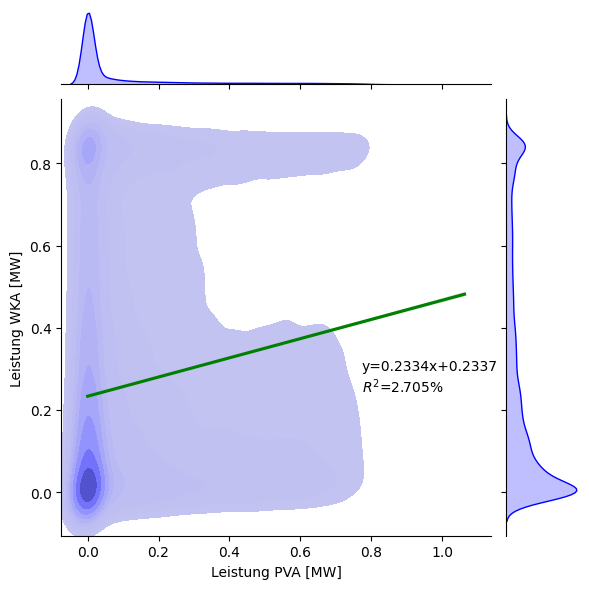

In [24]:
# -- Visualisierung der Verteilung von PVA- und WKA-Leistung
x = dict_data["center"]["df"][0]["P_pva_scalable"] / 1_000_000
y = dict_data["center"]["df"][0]["P_wka_scalable"] / 1_000_000

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

g = sns.JointGrid(x=x, y=y)

g.plot_joint(sns.kdeplot, color="blue", fill=True)
g.plot_marginals(sns.kdeplot, color="blue", fill=True)
g.plot_joint(sns.regplot, scatter=False, color="green", order=1)

g.ax_joint.set_xlabel("Leistung PVA [MW]")
g.ax_joint.set_ylabel("Leistung WKA [MW]")

g.ax_joint.annotate(
    "y=%.4fx+%.4f\n$R^2$=%.3f%%" % (slope, intercept, rvalue**2*100), 
    xy=(0.7, 0.33),
    xycoords="axes fraction"
)

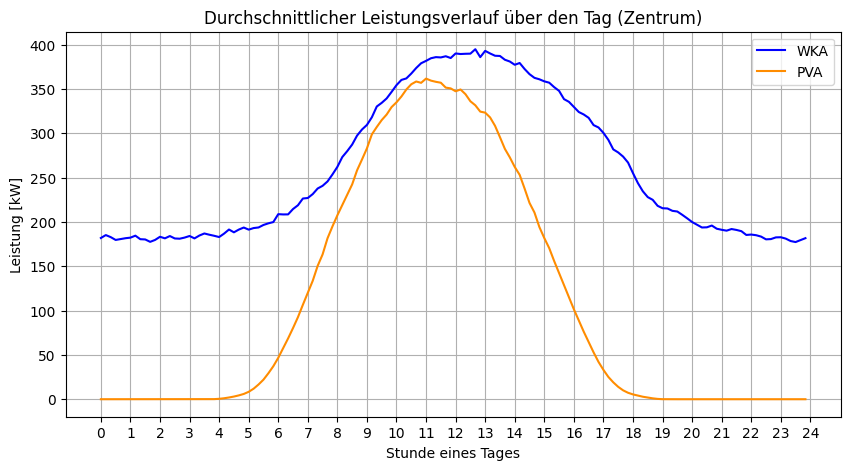

In [25]:
df_avg_day = dict_data["center"]["df"][0]
df_avg_day = df_avg_day[["P_pva_scalable", "P_wka_scalable"]].copy() / 1_000
df_avg_day["time"] = df_avg_day.index.hour + (df_avg_day.index.minute / 60) #month #

plt.figure(figsize=(10,5))
sns.lineplot(data=df_avg_day, x="time", y="P_wka_scalable", estimator="mean", errorbar=None, color="blue", label="WKA") #"sd"
sns.lineplot(data=df_avg_day, x="time", y="P_pva_scalable", estimator="mean", errorbar=None, color="darkorange", label="PVA") #"sd"
plt.xticks(ticks=[x for x in range(25)]) #1,13)]) #
plt.xlabel("Stunde eines Tages") #"Monat eines Jahres") #
plt.ylabel("Leistung [kW]")
plt.title("Durchschnittlicher Leistungsverlauf über den Tag (Zentrum)") #über ein Jahr (Zentrum)") #
plt.legend()
plt.grid(True)
plt.show()

-0.3082618996126791


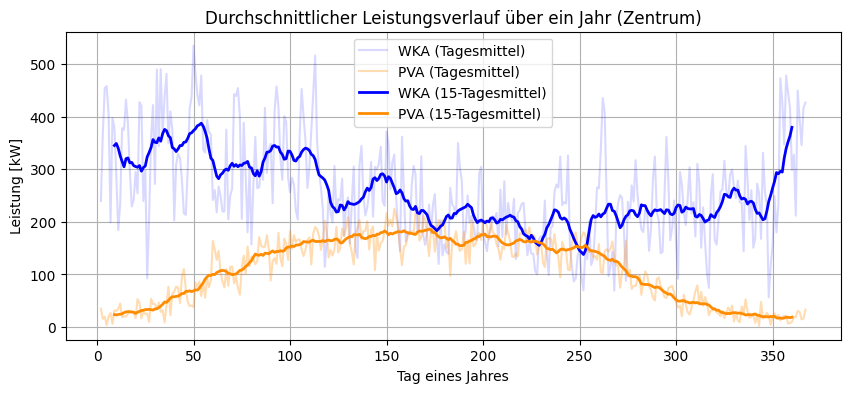

In [26]:
df_avg_year = dict_data["center"]["df"][0]
df_avg_year = df_avg_year[["P_pva_scalable", "P_wka_scalable"]].copy() / 1_000
df_avg_year["time"] = df_avg_year.index.day_of_year + 1

df_corr_avg_year = df_avg_year.groupby(df_avg_year.time).mean()
corr_avg_year = df_corr_avg_year.corr().at["P_pva_scalable","P_wka_scalable"]
print(corr_avg_year)

plt.figure(figsize=(10,4))

sns.lineplot(
    data=df_avg_year, x="time", y="P_wka_scalable", 
    estimator="mean", errorbar=None, 
    color="blue", alpha=0.15, 
    label="WKA (Tagesmittel)"
)
sns.lineplot(
    data=df_avg_year, x="time", y="P_pva_scalable", 
    estimator="mean", errorbar=None, 
    color="darkorange", alpha=0.3, 
    label="PVA (Tagesmittel)"
)

df_smoothed = df_avg_year.groupby("time").mean().rolling(window=15, center=True).mean()

sns.lineplot(
    x=df_smoothed.index, y=df_smoothed["P_wka_scalable"],
    color="blue", 
    linewidth=2, 
    label="WKA (15-Tagesmittel)"
)
sns.lineplot(
    x=df_smoothed.index, y=df_smoothed["P_pva_scalable"],
    color="darkorange", 
    linewidth=2, 
    label="PVA (15-Tagesmittel)"
)

plt.xlabel("Tag eines Jahres")
plt.ylabel("Leistung [kW]")
plt.title("Durchschnittlicher Leistungsverlauf über ein Jahr (Zentrum)")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
dict_corr = {}
for i_cd, df in enumerate(list_df_cardinal_direct):
    # Korrelationskoeffizient Allgemein
    corr_whole = df.corr().at["P_pva_scalable", "P_wka_scalable"]
    # Korrelationskoeffizient für Tagesverlauf
    df = df[["P_pva_scalable", "P_wka_scalable"]].copy() / 1_000
    df["time_avg_day"] = df.index.hour + (df.index.minute / 60)
    df_avg_day_avg = df.groupby(df.time_avg_day).mean()
    corr_avg_day_avg = df_avg_day_avg.corr().at["P_pva_scalable", "P_wka_scalable"]
    # Korrelationskoeffizient für Jahrenverlauf der Tage
    df["time_avg_year_day"] = df.index.day_of_year + 1
    df_avg_year_day = df.groupby(df.time_avg_year_day).mean()
    corr_avg_year_day = df_avg_year_day.corr().at["P_pva_scalable", "P_wka_scalable"]
    # Korrelationskoeffizient für Jahrenverlauf der Monate
    df["time_avg_year_mon"] = df.index.month
    df_avg_year_mon = df.groupby(df.time_avg_year_mon).mean()
    corr_avg_year_mon = df_avg_year_mon.corr().at["P_pva_scalable", "P_wka_scalable"]

    dict_corr[list_str_cardinal_direct[i_cd]] = {
        "Allgemein": corr_whole,
        "durchschnittlicher Tagesverlauf": corr_avg_day_avg,
        "Jahresverlauf durchschnittlicher Tage": corr_avg_year_day,
        "Jahresverlauf durchschnittlicher Monate": corr_avg_year_mon
    }

df_corr = pd.DataFrame(dict_corr).round(3)
df_corr.index.name = "Korrelationskoeffizient"
display(df_corr)

,Norden,Osten,Süden,Westen,Zentrum
Korrelationskoeffizient,,,,,
Allgemein,0.100,0.066,0.156,0.061,0.164
durchschnittlicher Tagesverlauf,0.976,0.944,0.957,0.978,0.896
Jahresverlauf durchschnittlicher Tage,-0.492,-0.539,-0.196,-0.611,-0.308
Jahresverlauf durchschnittlicher Monate,-0.689,-0.815,-0.287,-0.824,-0.430


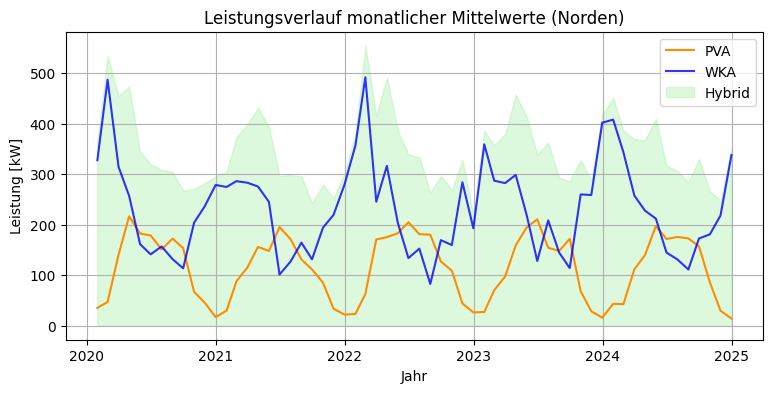

0.556021214702465 0.3983126104396425 0.2090416687767545


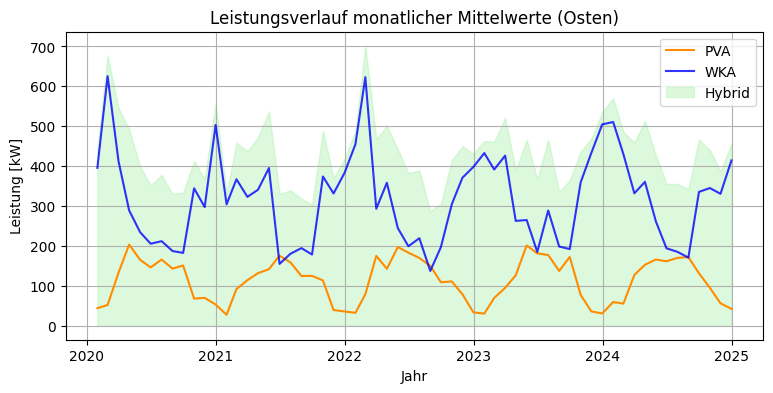

0.4645616344598552 0.35572244920399276 0.19547074533751324


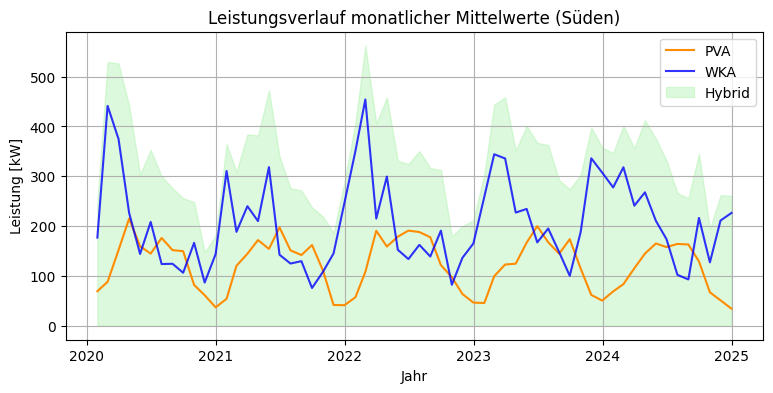

0.41256047053206374 0.4304408977854096 0.2736547112131413


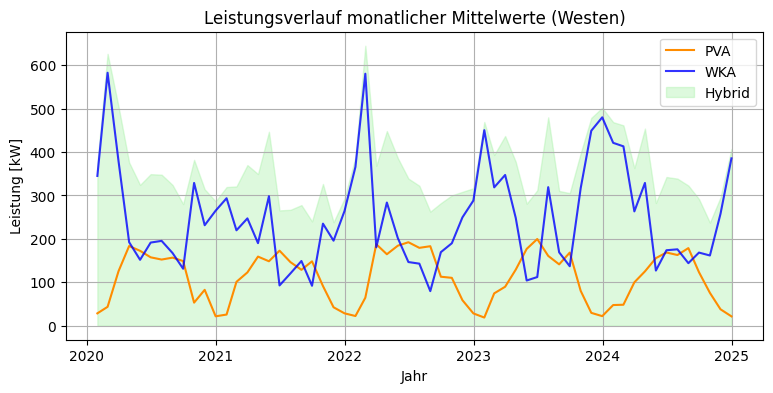

0.5205994152853904 0.4686452919766533 0.23911040226909064


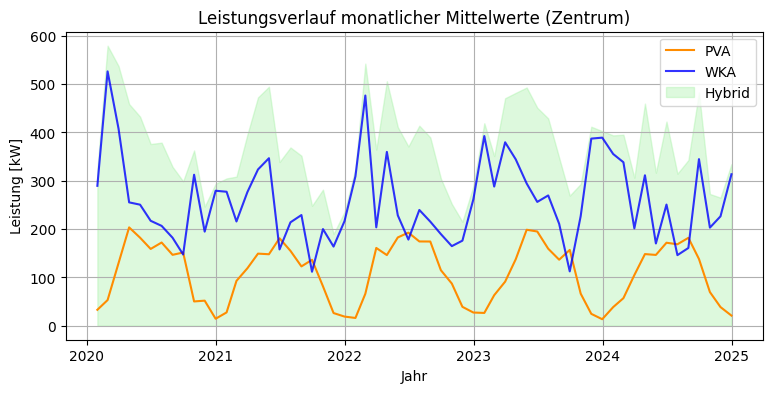

0.5533277273030018 0.332941593266016 0.23576500386241614


In [28]:
for i_cd, cd in enumerate(list_str_cardinal_direct_eng):    
    df = dict_data[cd]["df"][0].resample("ME").mean()
    y_pva = df["P_pva_scalable"] / 1_000 
    y_wka = df["P_wka_scalable"] / 1_000
    y_hyb = y_pva + y_wka
    x = df.index

    plt.figure(figsize=(9,4))
    plt.plot(x, y_pva, color="darkorange", label="PVA")
    plt.plot(x, y_wka, color="blue", alpha=0.8, label="WKA")
    plt.fill_between(x, 0, y_hyb, color="lightgreen", alpha=0.3, label="Hybrid")
    plt.xlabel("Jahr")
    plt.ylabel("Leistung [kW]")
    plt.title(f"Leistungsverlauf monatlicher Mittelwerte ({list_str_cardinal_direct[i_cd]})")
    plt.grid(True)
    plt.legend()
    plt.show()

    cv_pva = np.std(y_pva) / np.mean(y_pva)
    cv_wka = np.std(y_wka) / np.mean(y_wka)
    cv_hyb = np.std(y_hyb) / np.mean(y_hyb)
    print(cv_pva, cv_wka, cv_hyb)

In [29]:
dict_cv = {}
for i_cd, df in enumerate(list_df_cardinal_direct):

    y_pva = df["P_pva_scalable"] / 1_000
    y_wka = df["P_wka_scalable"] / 1_000
    y_hyb = y_pva + y_wka

    cv_pva = np.std(y_pva) / np.mean(y_pva)
    cv_wka = np.std(y_wka) / np.mean(y_wka)
    cv_hyb = np.std(y_hyb) / np.mean(y_hyb)

    dict_cv[list_str_cardinal_direct[i_cd]] = {
        "PVA": cv_pva,
        "WKA": cv_wka,
        "Hybrid": cv_hyb
    }

df_cv = pd.DataFrame(dict_cv)
df_cv.index.name = "Variationskoeffizient"
display(df_cv.round(3))

,Norden,Osten,Süden,Westen,Zentrum
Variationskoeffizient,,,,,
PVA,1.796,1.782,1.729,1.812,1.822
WKA,1.128,0.952,1.405,1.176,1.088
Hybrid,1.006,0.870,1.170,1.015,1.007


In [30]:
# -- Erstellen des dicts, welches die Ergebnisse aus mehreren manuellen Durchläufen speichert
dict_results_overview = {}
dict_results_NPV = {}

In [31]:
# -- Modellannahmen
def lin_interp_extrap(x_new, x, y):
    n = - (y[-1] - y[0]) / (x[-1] - x[0]) * x[-1] + y[-1]
    y_new = (y[-1] - y[0]) / (x[-1] - x[0]) * x_new + n
    return y_new

# - DataFrame für Optimierung
i_cd = 4 # 0:"north", 1:"east", 2:"south", 3:"west", 4:"center"
df_solve = dict_data[list_str_cardinal_direct_eng[i_cd]]["df"][0].loc["2020-01-01":"2024-12-31",:] # hier durchrotieren

# - Netzeinspeisung
# FiT = 0.07 # €/kWh, (feed-in tariff)
NAP_max = 1_000_000

# - Kosten PVA
# 950 kWh/(m²a): ~ 6,2 ct/kWh; 1120 kWh/(m²a): ~ 5,7 ct/kWh
x_pva_1 = [950, 1120] # FLH
y_pva_1 = [0.062, 0.057] # LCOE
# 1120 kWh/(m²a): ~ 5,7 ct/kWh; 1300 kWh/(m²a): ~ 4,5 ct/kWh
x_pva_2 = [1120, 1300] # FLH
y_pva_2 = [0.057, 0.045] # LCOE 
# LCOE-Berechnung
irr_pva = df_weather_mean.loc["Ø globale Einstrahlungsenergie [kWh/(m²a)]", list_str_cardinal_direct[i_cd]]
if irr_pva < x_pva_1[1]:
    LCOE_pva = lin_interp_extrap(irr_pva, x_pva_1, y_pva_1)
else:
    LCOE_pva = lin_interp_extrap(irr_pva, x_pva_2, y_pva_2)
print("Ø globale Einstrahlung [kWh/(m²a)]:", irr_pva, "LCOE:", LCOE_pva.round(4))

# - Kosten WKA
# 1800 FLH: 7,1 ct/kWh – 9,2 ct/kWh; 2500 FLH: 5,3 ct/kWh – 6,8 ct/kWh
x_wka_1 = [1800, 2500] # FLH [5.5, 6.4]
y_wka_1 = [(0.071 + 0.092) / 2, (0.053 + 0.068) / 2] # LCOE
# 2500 FLH: 5,3 ct/kWh – 6,8 ct/kWh; 3200 FLH: 4,3 ct/kWh – 5,5 ct/kWh
x_wka_2 = [2500, 3200] # FLH [6.4, 7.8]
y_wka_2 = [(0.053 + 0.068) / 2, (0.043 + 0.055) / 2] # LCOE 
# LCOE-Berechnung
FLH_wka = df_wka.loc["Ø Volllaststunden [h/a]", list_str_cardinal_direct[i_cd]] #Ø Windgeschwindigkeit Nabenhöhe [m/s]
if FLH_wka < x_wka_1[1]:
    LCOE_wka = lin_interp_extrap(FLH_wka, x_wka_1, y_wka_1)
else:
    LCOE_wka = lin_interp_extrap(FLH_wka, x_wka_2, y_wka_2)
print("Ø Volllaststunden [h/a]:", FLH_wka, "LCOE:", LCOE_wka.round(4))

# - Kosten Batterie
cost_bat = 464 # €/kWh, Kosten für Kapazität ~1-10 MWh
cost_bat_exchange = cost_bat * 0.3 # Frauenhofer: 30 % Anfangsinvestition Batterieersatzkosten, Lebensdauerverhältnis PVA/Bat = 2
WACC_bat = 0.025 # Frauenhofer
CRF_bat = (WACC_bat * (1 + WACC_bat) ** 30) / ((1 + WACC_bat) ** 30 - 1) # Kapitalwiedergewinnungsfaktor
annuity_bat = (cost_bat + cost_bat_exchange) * CRF_bat # Annuität ~ 28.82 €/kWh
print(annuity_bat) 
NPV_bat_5y = 0 # initialisierter Nettobarwert für for-Schleife
for year in range(1, 6):
    NPV_bat_5y += annuity_bat / ((1 + WACC_bat) ** year) # Nettobarwert der Batteriekosten für 5 Jahre 133.89 €/kWh
print(NPV_bat_5y)

# - Faktoren
WACC_wka = 0.039 # konservativer WACC der teuersten Technologie (WKA)
WACC_pva = 0.035
factor_conv = 1 / 6000 # von Ø W (alle 10min) in Kilowattstunde
factor_discount = (1 / (1 + WACC_wka)) # Stromgestehungskosten nimmt WACC der LCOE_WKA mit 3,9 % an.
factor_discount_pva = (1 / (1 + WACC_pva))
factor_bat_EPR = 2 # Energie-Leistungsverhältnis, 2 Stunden unter voller Leistung laden
factor_bat_eff = 0.90 ** 0.5 # 90% Wirkungsgrad der Batterie, symmetrische Aufteilung für Laden und Entladen, sodass Produkt aus beidem 95%
count_timestemps_year = len(list_df_cardinal_direct[0]) / 5
print(count_timestemps_year)

Ø globale Einstrahlung [kWh/(m²a)]: 1101.62 LCOE: 0.0575
Ø Volllaststunden [h/a]: 2270.16 LCOE: 0.0674
28.81947289206172
133.89032839066903
52617.6


In [32]:
# -- Optimierungsmodell inklusive Auslegung einer Batterie
model = pyo.ConcreteModel()

list_time = list(df_solve.index) # Gesamtzeitraum (wenn bei df_solve nicht anders angegeben): 2020-01-01 00:00 - 2024-12-31 23:50

dict_time = {t: (i + 1) for i, t in enumerate(list_time)}
prev_t = {list_time[i]: list_time[i-1] for i in range(1, len(list_time))} # Zugriff auf vorherigen Timestep (t-1)

# - Parameter
# Set aus allen Zeitschritten
model.T = pyo.Set(initialize=list_time)
# der Index der Zeitschritte (für das Diskontieren wichtig)
model.t_index = pyo.Param(model.T, initialize=dict_time)
# PVA-Leistung
model.P_pva = pyo.Param(model.T, initialize=df_solve["P_pva_scalable"])
# WKA-Leistung
model.P_wka = pyo.Param(model.T, initialize=df_solve["P_wka_scalable"])
# Netzeinspeisevergütung
model.spotmarkt = pyo.Param(model.T, initialize=df_spotmarkt["Spotmarktpreis [€/kWh]"].loc[list_time[0]:list_time[-1]])
# NAP-Maximalleistung die eingespeist werden kann
model.NAP_max = pyo.Param(initialize=NAP_max)

# - Variablen 
# PVA-Skalierungsfaktor (bspw. bei 2 = 2 MW PVA)
model.x_pva = pyo.Var(domain=pyo.NonNegativeReals)
# WKA-Skalierungsfaktor (bspw. bei 1,5 = 1,5 MW PVA)
model.x_wka = pyo.Var(domain=pyo.NonNegativeReals)
# Kapazität der Batterie (maximal speicherbare Energie)
model.E_bat_max = pyo.Var(domain=pyo.NonNegativeReals) 
# momentan gespeichert Energie in Batterie 
model.E_bat = pyo.Var(model.T, domain=pyo.NonNegativeReals) 
# momentane Ladeadeleistung der Batterie 
model.P_bat_charge = pyo.Var(model.T, domain=pyo.NonNegativeReals) 
# momentane Entladeleistung der Batterie 
model.P_bat_discharge = pyo.Var(model.T, domain=pyo.NonNegativeReals) 
# Verlustenergie die nicht eingespeist und nicht von Batterie aufgenommen wird + Abreglung bei Negativpreisen (unrealistischer bei WKA) 
model.loss = pyo.Var(model.T, domain=pyo.NonNegativeReals)

# - Zielfunktion (Objective)
# Gewinn maximieren
def objective_func(model):
    revenue = sum(
        (
            model.P_wka[t] * model.x_wka 
            + model.P_pva[t] * model.x_pva
            + model.P_bat_discharge[t] 
            - model.P_bat_charge[t] 
            - model.loss[t]
        ) * model.spotmarkt[t]
        * (factor_discount ** (model.t_index[t] / count_timestemps_year)) # kontinuierliche Diskontierung in Zehnminuten-Schritten
        for t in model.T
    ) * factor_conv # Netzeinspeisung KWh*€/kWh
    
    cost_wka = sum(
        model.P_wka[t] 
        * (factor_discount ** (model.t_index[t] / count_timestemps_year)) # kontinuierliche Diskontierung in Zehnminuten-Schritten
        for t in model.T
    ) * model.x_wka * LCOE_wka * factor_conv # WKA-Kosten KWh*€/kWh bereits diskontiert
    
    cost_pva = sum(
        model.P_pva[t] 
        * (factor_discount_pva ** (model.t_index[t] / count_timestemps_year)) # kontinuierliche Diskontierung in Zehnminuten-Schritten
        for t in model.T
    ) * model.x_pva * LCOE_pva * factor_conv # PVA-Kosten KWh*€/kWh bereits diskontiert
    
    cost_battery = model.E_bat_max * NPV_bat_5y # Batteriekapazitätskosten KWh*€/kWh 
    
    return revenue - cost_wka - cost_pva - cost_battery  
model.objective = pyo.Objective(rule=objective_func, sense=pyo.maximize)

# - Einschränkungen (Constraints)
# Berücksichtigen der maximal in das Netz einzuspeisenden Leistung
def c_NAP_limit(model, t):
    return (
        0, ( # Null als untere Grenze (relevant gegen das Phantomladen der Batterie)
            model.P_wka[t] * model.x_wka 
            + model.P_pva[t] * model.x_pva
            + model.P_bat_discharge[t] 
            - model.P_bat_charge[t] 
            - model.loss[t]
        ), model.NAP_max # 1_000_000 (NAP_max) als maximal einzuspeisende Leistung
    )
model.c_NAP_limit = pyo.Constraint(model.T, rule=c_NAP_limit)
# Batterieleistung eingrenzen (Batterie entladen)
def c_battery_discharge_limit(model, t): 
    return model.P_bat_discharge[t] * factor_bat_EPR <= model.E_bat_max * 1_000 # Entladeleistung im Verhältnis zur Kapazität: 2 
model.c_battery_discharge_limit = pyo.Constraint(model.T, rule=c_battery_discharge_limit) 
# Batterieleistung eingrenzen (Batterie laden) 
def c_battery_charge_limit(model, t): 
    return model.P_bat_charge[t] * factor_bat_EPR <= model.E_bat_max * 1_000 # Ladeleistung im Verhältnis zur Kapazität: 2 
model.c_battery_charge_limit = pyo.Constraint(model.T, rule=c_battery_charge_limit) 
# Batteriekapazität eingrenzen 
def c_battery_capacity_limit(model, t): 
    return model.E_bat[t] <= model.E_bat_max 
model.c_battery_capacity_limit = pyo.Constraint(model.T, rule=c_battery_capacity_limit) 
# momentanen Batteriestand definieren 
def c_battery_energy (model, t): 
    if t == list_time[0]: 
        return model.E_bat[t] == 0 
    else: 
        return model.E_bat[t] == ( 
            model.E_bat[prev_t[t]]  
            + ( 
                model.P_bat_charge[prev_t[t]] * factor_bat_eff 
                - model.P_bat_discharge[prev_t[t]] * (1 / factor_bat_eff) 
            ) * factor_conv 
        ) # model.E_bat(_max) somit Einheit kWh 
model.c_battery_energy = pyo.Constraint(model.T, rule=c_battery_energy) 

opt = SolverFactory("gurobi")

results = opt.solve(model, keepfiles=False, logfile="solve.log") #, keepfiles=False, logfile="solve.log"

In [33]:
df_result = pd.DataFrame({
    "E_bat": [pyo.value(model.E_bat[t]) for t in model.T], 
    "P_bat": [pyo.value(model.P_bat_discharge[t]) - pyo.value(model.P_bat_charge[t]) for t in model.T], 
    "loss": [pyo.value(model.loss[t]) for t in model.T],
    "price": [pyo.value(model.spotmarkt[t]) for t in model.T]
}, index=model.T).join([
    df_solve["P_pva_scalable"] * pyo.value(model.x_pva), 
    df_solve["P_wka_scalable"] * pyo.value(model.x_wka)
]).rename(columns={"P_pva_scalable": "P_pva_model", "P_wka_scalable": "P_wka_model"}) 

dict_results_overview_temp = {
    "Nennleistung PVA [MW]": float(round(pyo.value(model.x_pva), 3)),
    "Nennleistung WKA [MW]": float(round(pyo.value(model.x_wka), 3)),
    "Kapazität Batterie [kWh]": float(round(pyo.value(model.E_bat_max), 3)), 
    "LCOE PVA [ct/kWh]": round(LCOE_pva * 100, 3),
    "LCOE WKA [ct/kWh]": round(LCOE_wka * 100, 3),
    "Kapitalwert über 5 Jahre [€]": float(round(pyo.value(model.objective), 3))
}
dict_results_overview[list_str_cardinal_direct[i_cd]] = dict_results_overview_temp
df_results_overview = pd.DataFrame(dict_results_overview)
display(df_results_overview)

,Zentrum
Nennleistung PVA [MW],1.787
Nennleistung WKA [MW],1.122
Kapazität Batterie [kWh],1760.216
LCOE PVA [ct/kWh],5.754
LCOE WKA [ct/kWh],6.740
Kapitalwert über 5 Jahre [€],359171.553


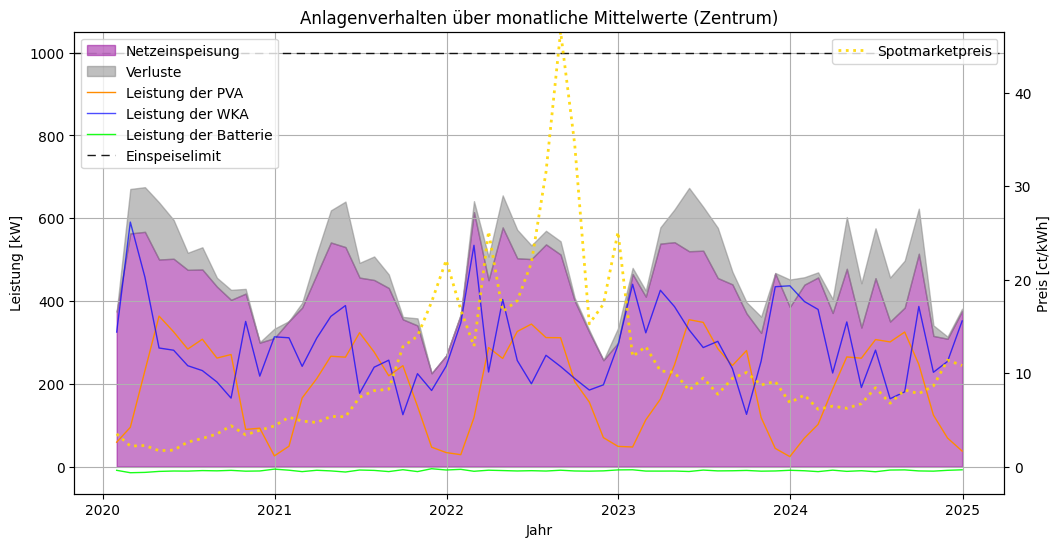

In [34]:
# -- Visualisierung der Modellausgaben
df_result_for_visualization = df_result.loc[
    "2020-01-01 00:00:00":"2024-12-31 23:50:00", ("P_pva_model", "P_wka_model", "P_bat", "loss", "price")
    ].resample("ME").mean()
# 2023-04-30
# df_result_for_visualization = df_result_for_visualization.groupby(df_result_for_visualization.index.time).mean()

x = df_result_for_visualization.index #[t.hour + t.minute / 60 for t in df_result_for_visualization.index] #
y_pva = df_result_for_visualization["P_pva_model"] / 1_000
y_wka = df_result_for_visualization["P_wka_model"] / 1_000
y_bat = df_result_for_visualization["P_bat"] / 1_000 
y_loss = df_result_for_visualization["loss"] / 1_000
y_price = df_result_for_visualization["price"] * 100
y_sum = y_wka + y_pva - y_loss + y_bat 

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.fill_between(x, 0, y_sum, label="Netzeinspeisung", color="#920097FF", alpha=0.5)
ax1.fill_between(x, y_sum, (y_sum + y_loss), label="Verluste", color="grey", alpha=0.5)
ax1.plot(x, y_pva, label="Leistung der PVA", linewidth=1, color="darkorange", alpha=1)
ax1.plot(x, y_wka, label="Leistung der WKA", linewidth=1, color="blue", alpha=0.7)
ax1.plot(x, y_bat, label="Leistung der Batterie", linewidth=1, color="lime", alpha=0.9) 
ax1.axhline((NAP_max/1000), label="Einspeiselimit", linestyle=(0, (6, 4)), color="black", linewidth=1, alpha=0.9)
ax1.set_ylabel("Leistung [kW]")
ax1.set_xlabel("Jahr") ######### Stunden
ax1.legend(loc="upper left")

# ax1.set_xticks([0, 4, 8, 12, 16, 20, 24]) #########

plt.grid(True) # Grid auf ax1 beziehen

ax2 = ax1.twinx()
ax2.plot(x, y_price, label="Spotmarketpreis", linestyle=":", linewidth=2, color="gold", alpha=0.9)
ax2.set_ylabel("Preis [ct/kWh]")
ax2.legend(loc="upper right")
# Funktion zum Synchronisieren beider y-Achsen bei y=0
def sync_y_axes_on_zero(ax1, ax2, data_ax2): 
    y1_min, y1_max = ax1.get_ylim()

    ratio_zero_placement = abs(y1_min) / (y1_max - y1_min) # auf welcher Höhe die Null relativ zu y1_min und y1_max liegt

    data_ax2_min = np.min(data_ax2)
    data_ax2_max = np.max(data_ax2)

    range_ax2 = max(
        data_ax2_max / (1 - ratio_zero_placement) if (1 - ratio_zero_placement) > 0 else float("inf"),
        abs(data_ax2_min) / ratio_zero_placement if ratio_zero_placement > 0 else float("inf")
    )

    ax2.set_ylim(-ratio_zero_placement * range_ax2, (1 - ratio_zero_placement) * range_ax2)
sync_y_axes_on_zero(ax1, ax2, y_price)

plt.title(f"Anlagenverhalten über monatliche Mittelwerte ({list_str_cardinal_direct[i_cd]})") # durchschnittlichen Tag
plt.show()

In [35]:
df_result[(df_result["P_pva_model"] < 0) & (df_result["P_wka_model"] <= 0)]

,E_bat,P_bat,loss,price,P_pva_model,P_wka_model


In [36]:
# - Kosten Batterie
cost_bat = 464 # €/kWh, Kosten für Kapazität ~1-10 MWh
cost_bat_exchange = cost_bat * 0.3 # Frauenhofer: 30 % Anfangsinvestition Batterieersatzkosten, Lebensdauerverhältnis PVA/Bat = 2
WACC_bat = 0.025 # Frauenhofer
CRF_bat = (WACC_bat * (1 + WACC_bat) ** 30) / ((1 + WACC_bat) ** 30 - 1) # Kapitalwiedergewinnungsfaktor
annuity_bat = (cost_bat + cost_bat_exchange) * CRF_bat # Annuität ~ 28.82 €/kWh
NPV_bat_5y = 0 # initialisierter Nettobarwert für for-Schleife
for year in range(1, 6):
    NPV_bat_5y += annuity_bat / ((1 + WACC_bat) ** year) # Nettobarwert der Batteriekosten für 5 Jahre 133.89 €/kWh

# - Faktoren
WACC_wka = 0.039 # konservativer WACC der teuersten Technologie (WKA)
WACC_pva = 0.035
factor_conv = 1 / 6000 # von Ø W (alle 10min) in Kilowattstunde
factor_discount = (1 / (1 + WACC_wka)) # Stromgestehungskosten nimmt WACC der LCOE_WKA mit 3,9 % an.
factor_discount_pva = (1 / (1 + WACC_pva))
factor_bat_EPR = 2 # Energie-Leistungsverhältnis, 2 Stunden unter voller Leistung laden
factor_bat_eff = 0.90 ** 0.5 # 90% Wirkungsgrad der Batterie, symmetrische Aufteilung für Laden und Entladen, sodass Produkt aus beidem 95%
count_timestemps_year = len(list_df_cardinal_direct[0]) / 5

# dict als Speicherplatz
dict_results_overview = {}
dict_results_NPV = {}

# Spotmarktpreise des Vergleichzeitraumes auf gleichen Index konvertieren
df_spotmarkt_compare = df_spotmarkt_full.loc["2015-01-01 00:00:00":"2020-01-01 23:50:00"]
df_spotmarkt_compare.index = list_df_cardinal_direct[0].index

# Optimierungsprozess und Visualisierung der Ergebnisse für jeden Anlagenstandort 
for i_cd in range(0,5):
    list_str_cardinal_direct_eng = ["north", "east", "south", "west", "center"]
    df_solve = dict_data[list_str_cardinal_direct_eng[i_cd]]["df"][0]

    # - Kosten PVA
    # 950 kWh/(m²a): ~ 6,2 ct/kWh; 1120 kWh/(m²a): ~ 5,7 ct/kWh
    x_pva_1 = [950, 1120]
    y_pva_1 = [0.062, 0.057]
    # 1120 kWh/(m²a): ~ 5,7 ct/kWh; 1300 kWh/(m²a): ~ 4,5 ct/kWh
    x_pva_2 = [1120, 1300]
    y_pva_2 = [0.057, 0.045]
    # LCOE-Berechnung
    irr_pva = df_weather_mean.loc["Ø globale Einstrahlungsenergie [kWh/(m²a)]", list_str_cardinal_direct[i_cd]]
    if irr_pva < x_pva_1[1]:
        LCOE_pva = lin_interp_extrap(irr_pva, x_pva_1, y_pva_1)
    else:
        LCOE_pva = lin_interp_extrap(irr_pva, x_pva_2, y_pva_2)
    print("Ø globale Einstrahlung [kWh/(m²a)]:", irr_pva, "LCOE:", LCOE_pva.round(4))

    # - Kosten WKA
    # 1800 FLH: 7,1 ct/kWh – 9,2 ct/kWh; 2500 FLH: 5,3 ct/kWh – 6,8 ct/kWh
    x_wka_1 = [1800, 2500]
    y_wka_1 = [(0.071 + 0.092) / 2, (0.053 + 0.068) / 2]
    # 2500 FLH: 5,3 ct/kWh – 6,8 ct/kWh; 3200 FLH: 4,3 ct/kWh – 5,5 ct/kWh
    x_wka_2 = [2500, 3200]
    y_wka_2 = [(0.053 + 0.068) / 2, (0.043 + 0.055) / 2]
    # LCOE-Berechnung
    FLH_wka = df_wka.loc["Ø Volllaststunden [h/a]", list_str_cardinal_direct[i_cd]]
    if FLH_wka < x_wka_1[1]:
        LCOE_wka = lin_interp_extrap(FLH_wka, x_wka_1, y_wka_1)
    else:
        LCOE_wka = lin_interp_extrap(FLH_wka, x_wka_2, y_wka_2)
    print("Ø Volllaststunden [h/a]:", FLH_wka, "LCOE:", LCOE_wka.round(4))


    # -- Optimierungsmodell inklusive Auslegung einer Batterie
    model = pyo.ConcreteModel()
    # Gesamtzeitraum (wenn bei df_solve nicht anders angegeben): 2020-01-01 00:00 - 2024-12-31 23:50
    list_time = list(df_solve.index) 
    
    dict_time = {t: (i + 1) for i, t in enumerate(list_time)}
    # Zugriff auf vorherigen Timestep (t-1)
    prev_t = {list_time[i]: list_time[i-1] for i in range(1, len(list_time))}
    
    #mean_price_observed = df_spotmarkt["Spotmarktpreis [€/kWh]"].loc[list_time[0]:list_time[-1]].mean()

    # - Parameter
    # Set aus allen Zeitschritten
    model.T = pyo.Set(initialize=list_time)
    # der Index der Zeitschritte (für das Diskontieren wichtig)
    model.t_index = pyo.Param(model.T, initialize=dict_time)
    # PVA-Leistung
    model.P_pva = pyo.Param(model.T, initialize=df_solve["P_pva_scalable"])
    # WKA-Leistung
    model.P_wka = pyo.Param(model.T, initialize=df_solve["P_wka_scalable"]) 
    # Netzeinspeisevergütung
    model.spotmarkt = pyo.Param(model.T, initialize=df_spotmarkt["Spotmarktpreis [€/kWh]"]) #df_spotmarkt_compare["Spotmarktpreis [€/kWh]"]) #
    # NAP-Maximalleistung die eingespeist werden kann
    model.NAP_max = pyo.Param(initialize=NAP_max)

    # - Variablen 
    # PVA-Skalierungsfaktor (bspw. bei 2 = 2 MW PVA)
    model.x_pva = pyo.Var(domain=pyo.NonNegativeReals)
    # WKA-Skalierungsfaktor (bspw. bei 1,5 = 1,5 MW PVA)
    model.x_wka = pyo.Var(domain=pyo.NonNegativeReals) 
    # Kapazität der Batterie (maximal speicherbare Energie)
    model.E_bat_max = pyo.Var(domain=pyo.NonNegativeReals) 
    # momentan gespeichert Energie in Batterie 
    model.E_bat = pyo.Var(model.T, domain=pyo.NonNegativeReals, initialize=0) 
    # momentane Ladeadeleistung der Batterie 
    model.P_bat_charge = pyo.Var(model.T, domain=pyo.NonNegativeReals) 
    # momentane Entladeleistung der Batterie 
    model.P_bat_discharge = pyo.Var(model.T, domain=pyo.NonNegativeReals) 
    # Verlustenergie die nicht eingespeist und nicht von Batterie aufgenommen wird + Abreglung bei Negativpreisen (Vereinfachung bei WKA) 
    model.loss = pyo.Var(model.T, domain=pyo.NonNegativeReals)

    # - Zielfunktion (Objective)
    # Gewinn maximieren
    def objective_func(model):
        revenue = sum(
            (
                model.P_wka[t] * model.x_wka  
                + model.P_pva[t] * model.x_pva
                + model.P_bat_discharge[t]  
                - model.P_bat_charge[t] 
                - model.loss[t]
            ) * model.spotmarkt[t] #mean_price_observed #
            * (factor_discount ** (model.t_index[t] / count_timestemps_year))
            for t in model.T
        ) * factor_conv
        
        cost_wka = sum( 
            model.P_wka[t]  
            * (factor_discount ** (model.t_index[t] / count_timestemps_year)) 
            for t in model.T 
        ) * model.x_wka * LCOE_wka * factor_conv 
        
        cost_pva = sum(
            model.P_pva[t]
            * (factor_discount_pva ** (model.t_index[t] / count_timestemps_year))
            for t in model.T
        ) * model.x_pva * LCOE_pva * factor_conv
        
        cost_battery = model.E_bat_max * NPV_bat_5y 
        
        return revenue - cost_wka - cost_pva - cost_battery #  
    model.objective = pyo.Objective(rule=objective_func, sense=pyo.maximize)

    # - Einschränkungen (Constraints)
    # Berücksichtigen der maximal in das Netz einzuspeisenden Leistung
    def c_NAP_limit(model, t):
        return (
            0, ( #-model.NAP_max #
                model.P_wka[t] * model.x_wka  
                + model.P_pva[t] * model.x_pva
                + model.P_bat_discharge[t]  
                - model.P_bat_charge[t] 
                - model.loss[t]
            ), model.NAP_max 
        )
    model.c_NAP_limit = pyo.Constraint(model.T, rule=c_NAP_limit)
    ## spez. Betrachtung: keine Überbauung
    # def c_no_oversizing(model):
    #     return model.x_wka + model.x_pva <= 1  
    # model.c_no_oversizing = pyo.Constraint(rule=c_no_oversizing)
    # Batterieleistung eingrenzen (Batterie entladen)
    def c_battery_discharge_limit(model, t): 
        return model.P_bat_discharge[t] * factor_bat_EPR <= model.E_bat_max * 1_000 
    model.c_battery_discharge_limit = pyo.Constraint(model.T, rule=c_battery_discharge_limit) 
    # Batterieleistung eingrenzen (Batterie laden) 
    def c_battery_charge_limit(model, t): 
        return model.P_bat_charge[t] * factor_bat_EPR <= model.E_bat_max * 1_000 
    model.c_battery_charge_limit = pyo.Constraint(model.T, rule=c_battery_charge_limit) 
    # Batteriekapazität eingrenzen 
    def c_battery_capacity_limit(model, t): 
        return model.E_bat[t] <= model.E_bat_max 
    model.c_battery_capacity_limit = pyo.Constraint(model.T, rule=c_battery_capacity_limit) 
    # momentanen Batteriestand definieren 
    def c_battery_energy (model, t): 
        if t == list_time[0]: 
            return model.E_bat[t] == 0 
        else: 
            return model.E_bat[t] == ( 
                model.E_bat[prev_t[t]]  
                + ( 
                    model.P_bat_charge[prev_t[t]] * factor_bat_eff 
                    - model.P_bat_discharge[prev_t[t]] * (1 / factor_bat_eff) 
                ) * factor_conv 
            ) 
    model.c_battery_energy = pyo.Constraint(model.T, rule=c_battery_energy) 

    opt = SolverFactory("gurobi")

    results = opt.solve(model, keepfiles=False, logfile=f"solve{i_cd}.log")


    
    df_result = pd.DataFrame({
        "E_bat": [pyo.value(model.E_bat[t]) for t in model.T], 
        "P_bat": [pyo.value(model.P_bat_discharge[t]) - pyo.value(model.P_bat_charge[t]) for t in model.T], 
        "loss": [pyo.value(model.loss[t]) for t in model.T],
        "price": [pyo.value(model.spotmarkt[t]) for t in model.T]
    }, index=model.T).join([
        df_solve["P_pva_scalable"] * pyo.value(model.x_pva),
        df_solve["P_wka_scalable"] * pyo.value(model.x_wka) 
    ]).rename(columns={"P_wka_scalable": "P_wka_model", "P_pva_scalable": "P_pva_model"})   

    coef_var = (
            np.std(df_result["P_wka_model"] + df_result["P_pva_model"] + df_result["P_bat"])  
            / np.mean(df_result["P_wka_model"] + df_result["P_pva_model"] + df_result["P_bat"]) #   
        )

    NAP_usage = (
        df_result["P_pva_model"]
        + df_result["P_wka_model"] 
        + df_result["P_bat"] 
        - df_result["loss"]
    ).mean() / 1_000_000

    energy_loss = (
        df_result["loss"].mean() 
        / (
            df_result["P_pva_model"]
            + df_result["P_wka_model"] 
            + df_result["P_bat"] 
        ).mean()
    )

    dict_results_overview_temp = {
        "Nennleistung PVA [MW]": float(pyo.value(model.x_pva)),
        "Nennleistung WKA [MW]": float(pyo.value(model.x_wka)), 
        "Kapazität Batterie [kWh]": float(pyo.value(model.E_bat_max)), 
        "LCOE PVA [ct/kWh]": LCOE_pva * 100,
        "LCOE WKA [ct/kWh]": LCOE_wka * 100,
        # "Rauigkeitslänge [m]": list_roughness_lenght[i_cd],
        "Variationskoeffizient": coef_var,
        "Ø Auslastung des NAP [%]": NAP_usage * 100,
        "Ø Energieverlust [%]": energy_loss * 100,
        "Kapitalwert über 5 Jahre [€]": float(pyo.value(model.objective))
    }
    dict_results_overview[list_str_cardinal_direct[i_cd]] = dict_results_overview_temp
    df_results_overview = pd.DataFrame(dict_results_overview)
    display(df_results_overview.round(3))


    dict_results_NPV_year = {}
    list_years = [
        ["2020-01-01", "2020-12-31"],
        ["2021-01-01", "2021-12-31"],
        ["2022-01-01", "2022-12-31"],
        ["2023-01-01", "2023-12-31"],
        ["2024-01-01", "2024-12-31"],
    ]

    for i_ys, year_span in enumerate(list_years):

        revenue = sum(
            (
                model.P_wka[t] * model.x_wka 
                + model.P_pva[t] * model.x_pva
                + model.P_bat_discharge[t] 
                - model.P_bat_charge[t] 
                - model.loss[t]
            ) * model.spotmarkt[t] #mean_price_observed #
            * (factor_discount ** (model.t_index[t] / count_timestemps_year))
            for t in list(df_solve.loc[year_span[0]:year_span[1]].index)
        ) * factor_conv
        
        cost_wka = sum(
            model.P_wka[t] 
            * (factor_discount ** (model.t_index[t] / count_timestemps_year))
            for t in list(df_solve.loc[year_span[0]:year_span[1]].index)
        ) * model.x_wka * LCOE_wka * factor_conv
        
        cost_pva = sum(
            model.P_pva[t] 
            * (factor_discount_pva ** (model.t_index[t] / count_timestemps_year))
            for t in list(df_solve.loc[year_span[0]:year_span[1]].index)
        ) * model.x_pva * LCOE_pva * factor_conv
        
        cost_battery = model.E_bat_max * annuity_bat / (1 + WACC_bat) 
        
        NPV_year = revenue - cost_wka - cost_pva - cost_battery 

        dict_results_NPV_year[year_span[0][0:4]] = pyo.value(NPV_year)
    dict_results_NPV[list_str_cardinal_direct[i_cd]] = dict_results_NPV_year
    df_results_NPV = pd.DataFrame(dict_results_NPV)
    df_results_NPV.index.name = "Barwert [€]"

Ø globale Einstrahlung [kWh/(m²a)]: 1104.53 LCOE: 0.0575
Ø Volllaststunden [h/a]: 2021.52 LCOE: 0.0749


,Norden
Nennleistung PVA [MW],2.205
Nennleistung WKA [MW],0.470
Kapazität Batterie [kWh],1759.392
LCOE PVA [ct/kWh],5.746
LCOE WKA [ct/kWh],7.485
Variationskoeffizient,1.293
Ø Auslastung des NAP [%],31.683
Ø Energieverlust [%],9.870
Kapitalwert über 5 Jahre [€],275870.845


Ø globale Einstrahlung [kWh/(m²a)]: 1154.62 LCOE: 0.0547
Ø Volllaststunden [h/a]: 2771.96 LCOE: 0.056


,Norden,Osten
Nennleistung PVA [MW],2.205,1.759
Nennleistung WKA [MW],0.470,1.209
Kapazität Batterie [kWh],1759.392,1630.273
LCOE PVA [ct/kWh],5.746,5.469
LCOE WKA [ct/kWh],7.485,5.603
Variationskoeffizient,1.293,0.883
Ø Auslastung des NAP [%],31.683,51.015
Ø Energieverlust [%],9.870,11.121
Kapitalwert über 5 Jahre [€],275870.845,591951.334


Ø globale Einstrahlung [kWh/(m²a)]: 1258.1 LCOE: 0.0478
Ø Volllaststunden [h/a]: 1796.64 LCOE: 0.0816


,Norden,Osten,Süden
Nennleistung PVA [MW],2.205,1.759,2.458
Nennleistung WKA [MW],0.470,1.209,0.198
Kapazität Batterie [kWh],1759.392,1630.273,2000.000
LCOE PVA [ct/kWh],5.746,5.469,4.779
LCOE WKA [ct/kWh],7.485,5.603,8.160
Variationskoeffizient,1.293,0.883,1.434
Ø Auslastung des NAP [%],31.683,51.015,29.472
Ø Energieverlust [%],9.870,11.121,11.551
Kapitalwert über 5 Jahre [€],275870.845,591951.334,376378.713


Ø globale Einstrahlung [kWh/(m²a)]: 1080.43 LCOE: 0.0582
Ø Volllaststunden [h/a]: 2171.23 LCOE: 0.0704


,Norden,Osten,Süden,Westen
Nennleistung PVA [MW],2.205,1.759,2.458,2.212
Nennleistung WKA [MW],0.470,1.209,0.198,0.546
Kapazität Batterie [kWh],1759.392,1630.273,2000.000,1889.263
LCOE PVA [ct/kWh],5.746,5.469,4.779,5.816
LCOE WKA [ct/kWh],7.485,5.603,8.160,7.036
Variationskoeffizient,1.293,0.883,1.434,1.225
Ø Auslastung des NAP [%],31.683,51.015,29.472,33.695
Ø Energieverlust [%],9.870,11.121,11.551,9.244
Kapitalwert über 5 Jahre [€],275870.845,591951.334,376378.713,288518.893


Ø globale Einstrahlung [kWh/(m²a)]: 1101.62 LCOE: 0.0575
Ø Volllaststunden [h/a]: 2270.16 LCOE: 0.0674


,Norden,Osten,Süden,Westen,Zentrum
Nennleistung PVA [MW],2.205,1.759,2.458,2.212,1.787
Nennleistung WKA [MW],0.470,1.209,0.198,0.546,1.122
Kapazität Batterie [kWh],1759.392,1630.273,2000.000,1889.263,1760.216
LCOE PVA [ct/kWh],5.746,5.469,4.779,5.816,5.754
LCOE WKA [ct/kWh],7.485,5.603,8.160,7.036,6.740
Variationskoeffizient,1.293,0.883,1.434,1.225,1.031
Ø Auslastung des NAP [%],31.683,51.015,29.472,33.695,42.783
Ø Energieverlust [%],9.870,11.121,11.551,9.244,10.083
Kapitalwert über 5 Jahre [€],275870.845,591951.334,376378.713,288518.893,359171.553


In [37]:
pva_wka_bat_east = list_df_cardinal_direct[1]["P_pva_scalable"] * 1.759 + list_df_cardinal_direct[1]["P_wka_scalable"] * 1.209
pva_wka_bat_center = list_df_cardinal_direct[4]["P_pva_scalable"] * 1.787 + list_df_cardinal_direct[4]["P_wka_scalable"] * 1.122

print(
    "Variationskoeffizient der Referenzkonstellation ohne Batterie im Osten: ", 
    np.std(pva_wka_bat_east) / np.mean(pva_wka_bat_east)
)

print(
    "Variationskoeffizient der Referenzkonstellation ohne Batterie im Zentrum: ", 
    np.std(pva_wka_bat_center) / np.mean(pva_wka_bat_center)
)

Variationskoeffizient der Referenzkonstellation ohne Batterie im Osten:  0.9041628763884935
Variationskoeffizient der Referenzkonstellation ohne Batterie im Zentrum:  1.0562679292378476


In [38]:
# -- Visualisierung des Selbstverbrauchs der Wechselrichter bei PVA
dict_pva_inactivity = {}
for i_cd, df in enumerate(list_df_cardinal_direct):
    hours = 0
    loss_money = 0
    loss_energy = 0
    observed_years = 5
    self_consumption_kW = 0.34144
    pva_scale_factor = df_results_overview.iloc[0, i_cd]
    whole_NPV = df_results_overview.iloc[-1, i_cd]
    for i_time, counter in enumerate(df["P_pva_scalable"]):
        if counter == 0:
            hours += (1 / 6)
            loss_energy += self_consumption_kW * (1 / 6)
            loss_money += self_consumption_kW * (1 / 6) * df_spotmarkt.iloc[i_time, 0]
    dict_pva_inactivity[list_str_cardinal_direct[i_cd]] = {
        "Stunden der Inaktivität pro Jahr [h/a]": hours / observed_years,
        "Energieverlust bei 1 MW Nennleistung [kWh]": loss_energy,
        "Monetärer Verlust bei 1 MW Nennleistung [€]": loss_money,
        "Monetärer Verlust bei Referenzkonstellation [%]": (loss_money * pva_scale_factor / whole_NPV) * 100
    }

df_pva_inactivity = pd.DataFrame(dict_pva_inactivity)
display(df_pva_inactivity.round(2))

,Norden,Osten,Süden,Westen,Zentrum
Stunden der Inaktivität pro Jahr [h/a],4870.60,4803.43,4767.47,4994.50,4985.70
Energieverlust bei 1 MW Nennleistung [kWh],8315.09,8200.42,8139.02,8526.61,8511.59
Monetärer Verlust bei 1 MW Nennleistung [€],909.16,898.43,888.97,929.92,941.52
Monetärer Verlust bei Referenzkonstellation [%],0.73,0.27,0.58,0.71,0.47


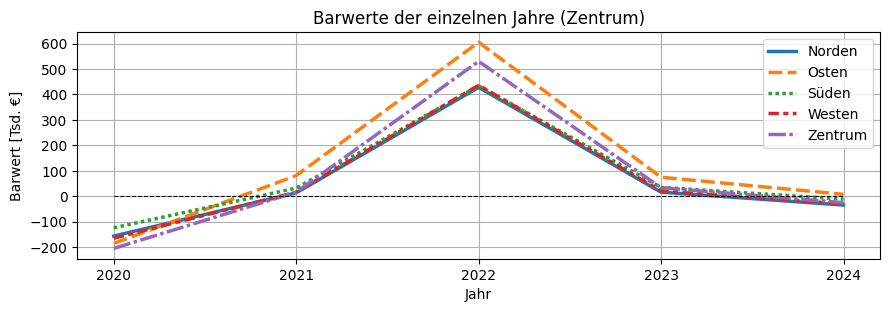

In [39]:
# -- Visualisierung der Barwerte pro Jahr
plt.figure(figsize=(9,3))
sns.lineplot(data=(df_results_NPV / 1_000) , linewidth = 2.5)
plt.xlabel("Jahr")
plt.ylabel("Barwert [Tsd. €]")
plt.yticks(np.arange(-200, 700, 100))
plt.plot(df_results_NPV.index, (0 * np.arange(0,5,1)), color="black", linestyle="--", linewidth=0.8)
plt.grid(True)
plt.tight_layout()
plt.title("Barwerte der einzelnen Jahre (Zentrum)");